In [1]:
import cantera as ct
import numpy as np
import time
#import scipy
import pandas as pd
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
import os 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
%matplotlib inline


print('This file was created by EHG on March 13, 2023')
print('Runnning Cantera version: ' + ct.__version__)

This file was created by EHG on March 13, 2023
Runnning Cantera version: 2.5.1


In [2]:
mechfile='/work/westgroup/nora/Code/projects/PFAS/ESSCI/models/RMG/H_F_families_only/chemkin/copies/copy_chem0140.cti'

In [26]:
mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_kinetics_flipped/anl_brown_flipping/ANL_brown5/ANL_brown5_template.yaml'

In [2]:
mechfile='/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_correct/nuig_brown.yaml'

In [11]:
#mechfile = '/work/westgroup/nora/Code/projects/PFAS/ESSCI/models/RMG/H_F_families_only/chemkin/copies/copy_chem_annotated.cti'
mechfile = '/work/westgroup/nora/Code/projects/PFAS/ESSCI/models/RMG/H_F_families_only/chemkin/copies/copy_chem0119.cti'

In [3]:
gas_full=ct.Solution(mechfile)
# use this toggle to use either the full mechanism (True) or a smaller version (False)
#FullMech = False
FullMech = True

if FullMech==False:
    
    #exclude = ['CH2CCHCH2CHCH2'] #add specific species here. (for illustration purposes, since the Max_N_oxygen below would eliminate it anyway)
    max_N_carbon = 4
    max_N_oxygen = 3
    
    all_species = ct.Species.listFromFile(mechfile)
    species = []
    # Filter species
    for S in all_species:
#         if S.name in exclude:
#             print( "excluding %s"%(S.name) )
#             continue #skip this species
        comp = S.composition
        if S.name in ['C6H9', 'C6H10']:
            continue
        if 'C' in comp and comp['C']> max_N_carbon:
            print( "excluding %s"%(S.name) )
            continue
        if 'O' in comp and comp['O']> max_N_oxygen:
            print( "excluding %s"%(S.name) )
            continue            
#         if 'He' in comp: # Exclude Helium
#             print( "excluding %s"%(S.name) )
#             continue
#         if 'Ar' in comp: # Exclude Argon
#             print( "excluding %s"%(S.name) )
#             continue
#         if 'Kr' in comp: # Exclude Krypton
#             print( "excluding %s"%(S.name) )
#             continue   
        #print S.name   
        species.append(S)

    species_names = {S.name for S in species}
    # Filter reactions, keeping only those that only involve the selected species
    all_reactions = gas_full.reactions()
    reactions = []

    for R in all_reactions:
        if not all(reactant in species_names for reactant in R.reactants):
            continue
        if not all(product in species_names for product in R.products):
            continue
        reactions.append(R)

    gas_small = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)
    gas = gas_small    
else:
    gas = gas_full
    
print( "final mechanism has %d species and %d reactions"%(gas.n_species, gas.n_reactions) )
# i_ch3no2 = gas.species_index('CH3NO2')

final mechanism has 140 species and 2533 reactions


In [4]:
##Compare the two mechanisms 
print(mechfile)
N_full = gas_full.n_species
N_small = gas_small.n_species

K_full = gas_full.n_reactions
K_small = gas_small.n_reactions

print('The old mechanism has N={0} and K ={1}'.format(N_full,K_full))
print('The new mechanism has N={0} and K ={1}'.format(N_small,K_small))

##export the mechanism, only for version 2.6.0
#gas_small.write_yaml(mech_name+"-reduced-{}-reaction.yaml".format(N_small))



/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_correct/nuig_brown.yaml
The old mechanism has N=2835 and K =11364
The new mechanism has N=663 and K =3776


In [4]:
#ign delay function 

def find_id(time,data):
    m = len(data)
    diff = np.zeros(m)
    diff_l = np.zeros(m)
    diff_r = np.zeros(m)
    a = 0
    for i in range(m):
        if i>1 and i<m-1:
            diff_l[i] = (data[i] - data[i-1])/(time[i]-time[i-1])
            diff_r[i] = (data[i+1] - data[i])/(time[i+1]-time[i])
            diff[i] = (diff_l[i]+diff_r[i])/2
    a = np.max(diff) #slope,m
    b = np.argmax(diff) #location of slope, x1
    
    
    #making of the function (y-y1 = m(x-x1)) 
    y = data[b] #location of y1
    x = time[b]  #location of x1 in terms of the modified time s
    
    #added by Nora 
    print(f'slope (a): {a}, location of slope (b): {b}, y: {y}, x: {x}')
    
    t_id = -y/a+x #ignition delay location
    
    
    #returning the slope approximation function 
    
    lo = x-0.005
    hi = x+0.005
   
    x_0  = np.linspace(lo,hi)
    y_0 = a*(x_0-x)+y
    print(f'in the find_id function, found :{t_id}')
    return diff,t_id,x_0,y_0

In [5]:
#doping data, eduardos experiments 

no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_label, no_CH2F2_color, no_CH2F2_shape  = [[0.63269666, 0.56358202, 0.61326454, 0.62338108, 0.6588242,  0.74256908,
 0.77973157, 0.74591045, 0.65343648, 0.6813308], 
 [0.140397, 0.03592654, 0.08382547, 0.1015549,  0.21059732, 1.74050565,
 3.16531584, 1.67252058, 0.19990897, 0.36081361], '0% CH$_2$F$_2$', 'k', 's']
                                                                      
                    
pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_label, pt1_CH2F2_color,  pt1_CH2F2_shape =[[0.71625797, 0.56876523, 0.58520137, 0.6216291, 0.70274495, 0.68888998,
 0.74213088], 
 [1.21382961, 0.0471075,  0.07372893, 0.12092486, 0.67064511, 0.55730096,
 2.02355779], '0.1% CH$_2$F$_2$', 'm', 's']
                                                          
    
pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_label, pt5_CH2F2_color,  pt5_CH2F2_shape  = [[0.64051452, 0.74256407, 0.75806182, 0.59921964, 0.55737473, 0.69714701,
 0.71456021, 0.68253075], 
 [0.19242997, 2.08706923, 2.24174715, 0.08639935, 0.04194953, 0.63637152,
 1.06022888, 0.4540505 ], '0.5% CH$_2$F$_2$', 'c', 'v'] 

_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_label, _2_CH2F2_color,  _2_CH2F2_shape = [[0.6014515, 0.72489571, 0.76260487, 0.63965302, 0.64586785, 0.66499352,
 0.66447004, 0.69194404, 0.55187601], 
 [0.12278134, 2.15618223, 3.8948634,  0.28953096, 0.36193926, 0.57132118,
 0.62294087, 1.16312355, 0.051226],  '2% CH$_2$F$_2$', 'b', '^']

_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_label, _4_CH2F2_color,  _4_CH2F2_shape = [[0.59342286, 0.56586408, 0.61717534, 0.66810691, 0.69578168, 0.71392225,
 0.52988636], 
 [0.2396125, 0.13106904, 0.40859232, 1.46789449, 2.3113845,  2.8922329,
 0.06264836], '4% CH$_2$F$_2$', 'g', 'o']

#this gets specific temperatures
temps_for_0 = sorted([1000/T_inv for T_inv in no_CH2F2_temps_inv])
temps_for_0_1 = sorted([1000/T_inv for T_inv in pt1_CH2F2_temps_inv])
temps_for_0_5 = sorted([1000/T_inv for T_inv in pt5_CH2F2_temps_inv])
temps_for_2 = sorted([1000/T_inv for T_inv in _2_CH2F2_temps_inv])
temps_for_4 = sorted([1000/T_inv for T_inv in _4_CH2F2_temps_inv])

[1282.4926403839208, 1340.6435048604026, 1346.676056051243, 1467.715829080382, 1517.8555978969807, 1530.3706337301523, 1580.5362399099752, 1604.1551982937947, 1630.6176776501704, 1774.364625755804]
['CH2F2(1):0, C3H8(2): 1, O2(3): 6, Ar:93', 'CH2F2(1):0.11,C3H8(2):1.1,O2(3):6,Ar:92.13', 'CH2F2(1):0.52,C3H8(2):1,O2(3):6,Ar:92.5', 'CH2F2(1):2,C3H8(2):1.1,O2(3):6,Ar:90.9', 'CH2F2(1):1.99,C3H8(2):0.5,O2(3):3,Ar:94.7']
starting 1282.4926403839208 of 0% CH2F2
Initializing reactor network.
Reactor 0: 143 variables.
              0 sensitivity params.
Number of equations: 143
Maximum time step:                0
slope (a): 53.159906357544216, location of slope (b): 784, y: 0.4006541856578083, x: 3.9249999999999243
in the find_id function, found :3.9174632262711846
starting 1340.6435048604026 of 0% CH2F2
Initializing reactor network.
Reactor 0: 143 variables.
              0 sensitivity params.
Number of equations: 143
Maximum time step:                0
slope (a): 53.93737889474639, location of

/tmp/ipykernel_12301/2214413358.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


slope (a): 59.08613346824225, location of slope (b): 66, y: 0.2960363695275742, x: 0.3350000000000006
in the find_id function, found :0.32998974882682663
starting 1561.2448567130064 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 143 variables.
              0 sensitivity params.
Number of equations: 143
Maximum time step:                0
slope (a): 66.60485134128933, location of slope (b): 26, y: 0.46429375837023923, x: 0.13500000000000004
in the find_id function, found :0.12802913002551192
starting 1668.837156272114 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 143 variables.
              0 sensitivity params.
Number of equations: 143
Maximum time step:                0
slope (a): 69.1803175370024, location of slope (b): 11, y: 0.4749191594900661, x: 0.060000000000000005
in the find_id function, found :0.053135053778322915
starting 1794.1251122023418 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 143 variables.
              0 sensitivity params.
Number of e

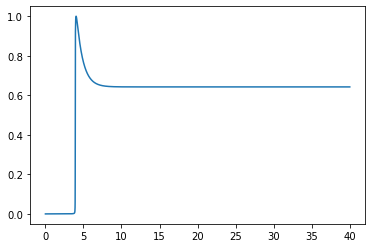

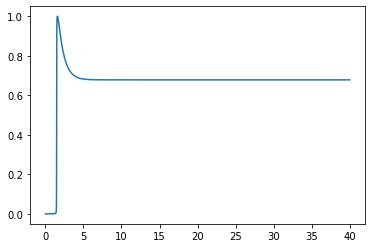

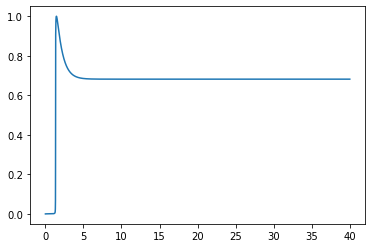

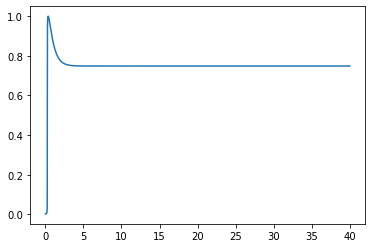

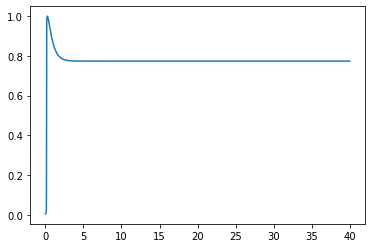

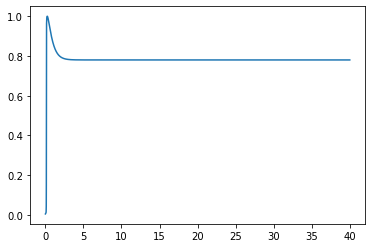

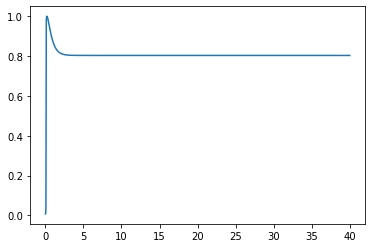

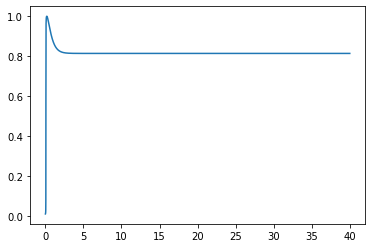

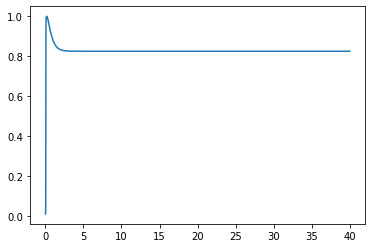

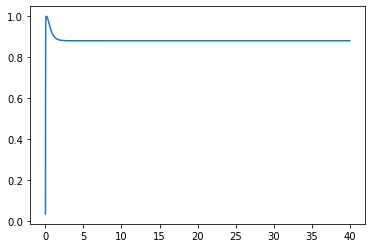

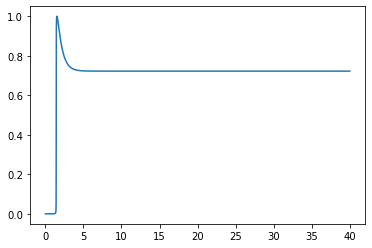

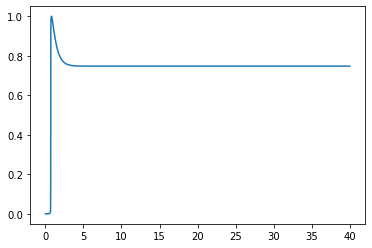

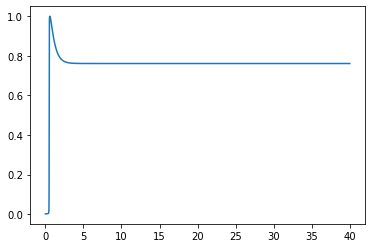

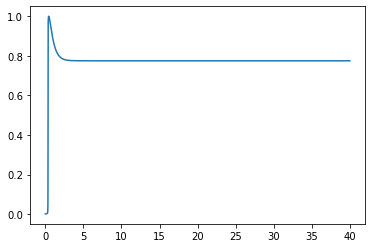

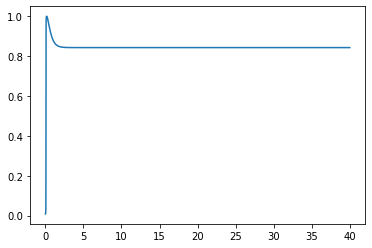

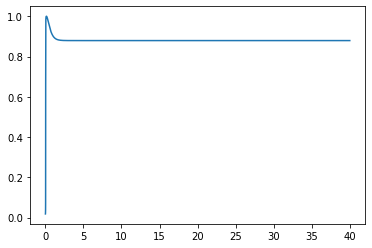

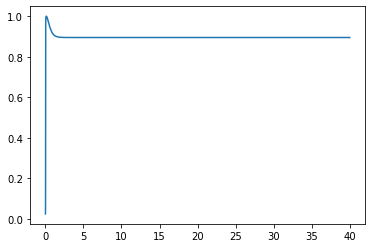

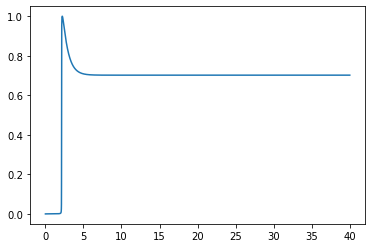

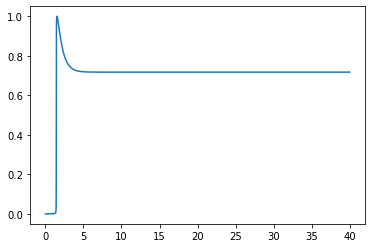

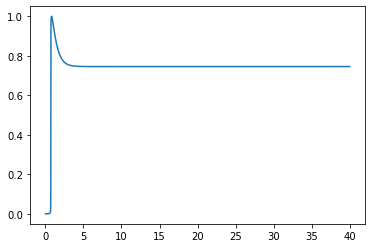

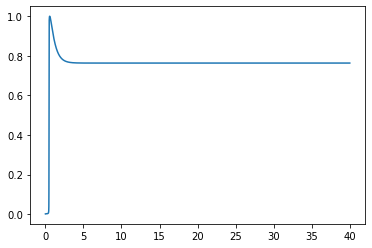

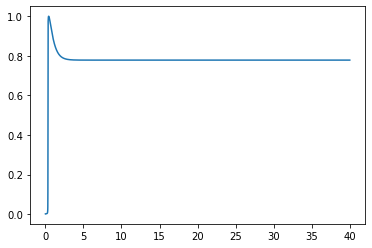

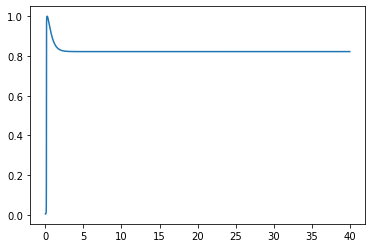

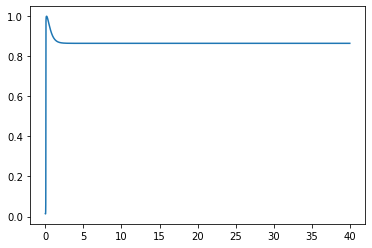

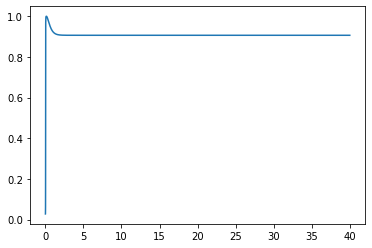

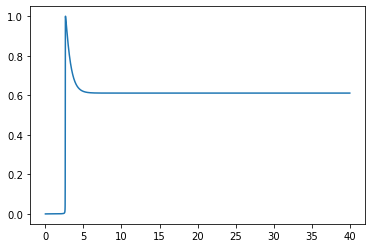

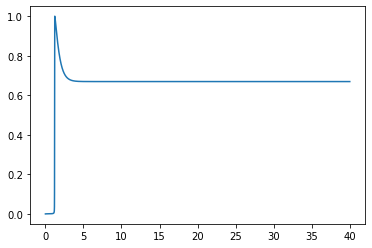

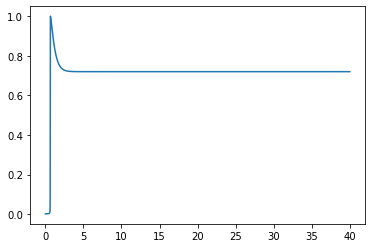

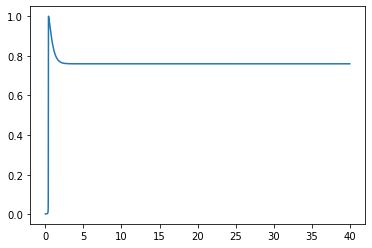

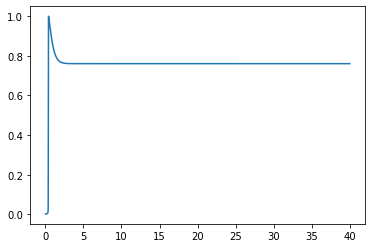

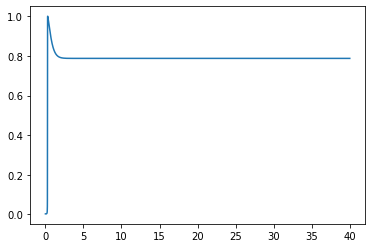

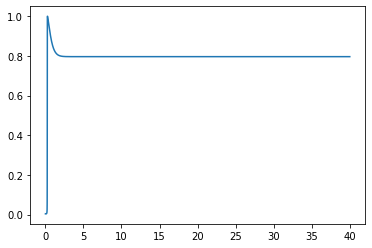

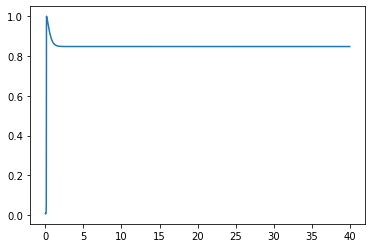

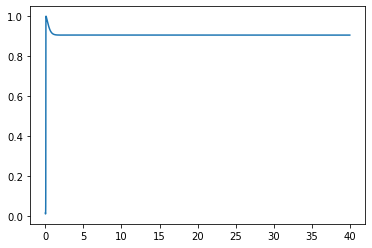

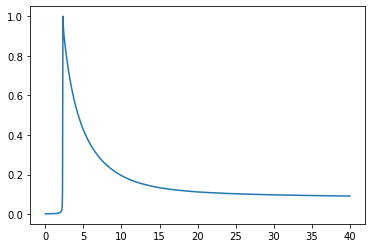

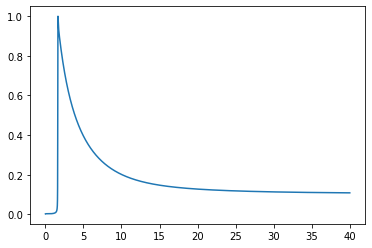

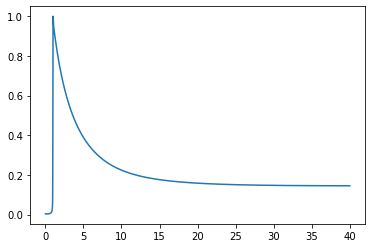

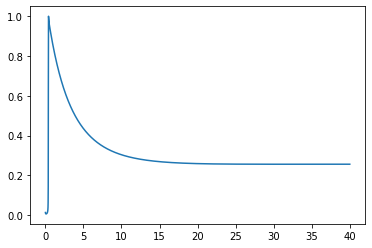

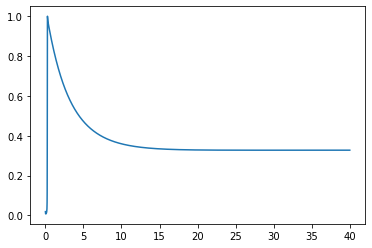

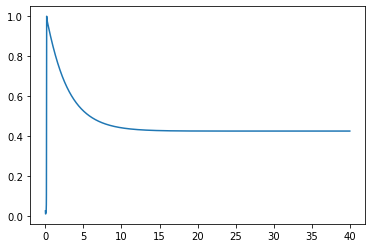

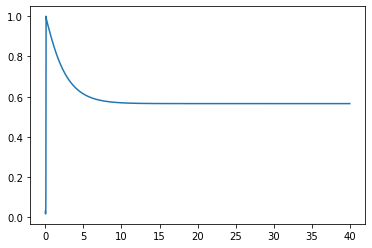

In [6]:
#doped propane (my model) 

#specific Ts

specific_temps = {0: temps_for_0,
0.1: temps_for_0_1,
0.5: temps_for_0_5,
2: temps_for_2,
4: temps_for_4}

X_list = [0,0.1,0.5,2,4]
concentrations = ['0','0.1', '0.5', '2', '4']
conc_names = ['CH2F2(1):0, C3H8(2): 1, O2(3): 6, Ar:93','CH2F2(1):0.11,C3H8(2):1.1,O2(3):6,Ar:92.13','CH2F2(1):0.52,C3H8(2):1,O2(3):6,Ar:92.5','CH2F2(1):2,C3H8(2):1.1,O2(3):6,Ar:90.9','CH2F2(1):1.99,C3H8(2):0.5,O2(3):3,Ar:94.7']

pressure_dict = {0: 1,  #I'm just assuming this is 1 atm for no CH2F2, there's actually no csv file for it
    0.1:  1.0127232051380075,
    0.5:  1.0158269373681306, 
    2: 1.012855580622881,
    4: 0.9891502432791955}

master_dict={}

for index, x in enumerate(X_list): 
    
    temps_we_want = specific_temps[x]
    print(temps_we_want)

    mole_frac_dict = conc_names[index]
    print(conc_names)
    
    t_id_nuig = np.zeros(len(temps_we_want))
    for i in range(len(temps_we_want)):
        print(f'starting {temps_we_want[i]} of {concentrations[index]}% CH2F2')
                        
        gas.TPX = temps_we_want[i],pressure_dict[x]*ct.one_atm, mole_frac_dict
        r = ct.Reactor(contents=gas)


        sim = ct.ReactorNet([r])
        sim.verbose = True

        states = ct.SolutionArray(gas, extra=['t'])
        
                
        dt_max = 5e-6
        t_end = (2000 * dt_max)*4
        #t_end = (2000 * dt_max)*10

        while sim.time < t_end:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time*1e3)


        diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH(7)')]/np.max(states.X[:, gas.species_index('OH(7)')]))
        #diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH(18)')]/np.max(states.X[:, gas.species_index('OH(18)')]))
        #diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH(21)')]/np.max(states.X[:, gas.species_index('OH(21)')]))
        t_id_nuig[i] = t_id #id in ms
        

        plt.figure()
        plt.plot(states.t,states.X[:, gas.species_index('OH(7)')]/np.max(states.X[:, gas.species_index('OH(7)')]))
        #plt.plot(states.t,states.X[:, gas.species_index('OH(18)')]/np.max(states.X[:, gas.species_index('OH(18)')]))
        #plt.plot(states.t,states.X[:, gas.species_index('OH(21)')]/np.max(states.X[:, gas.species_index('OH(21)')]))
#     #save the data   
    master_dict[x] = t_id_nuig



In [7]:
#RMG model, 91 species, Franklins edits
print(mechfile)
print(master_dict)

/work/westgroup/nora/Code/projects/PFAS/ESSCI/models/RMG/H_F_families_only/chemkin/copies/copy_chem0140.cti
{0: array([3.91746323, 1.46389239, 1.32942137, 0.24651783, 0.13922125,
       0.12344088, 0.07502063, 0.06097831, 0.04949029, 0.01609139]), 0.1: array([1.41415772, 0.69576112, 0.48508753, 0.3394696 , 0.06876251,
       0.03025457, 0.02149083]), 0.5: array([2.1183417 , 1.42388694, 0.70816285, 0.46362767, 0.32998975,
       0.12802913, 0.05313505, 0.02179055]), 2: array([2.60382234, 1.2001653 , 0.63042517, 0.3796874 , 0.37615462,
       0.2651895 , 0.23755719, 0.11878513, 0.04710073]), 4: array([2.25737239, 1.60976804, 0.96737754, 0.37632487, 0.23900464,
       0.13896311, 0.06761197])}


In [15]:
#MODIFIED RMG 

/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/with_franklins_edited_rates/chemkin/copies/copy_chem0119.cti #no modification besides franklins rates
{0: array([3.87338951, 1.44670745, 1.31348691, 0.23987305, 0.1355079 ,
       0.11973082, 0.07344896, 0.05961196, 0.04695901, 0.01428925]), 0.1: array([1.12915108, 0.58921879, 0.42415445, 0.30805652, 0.06977644,
       0.03072537, 0.02164341]), 0.5: array([1.01711323, 0.76780072, 0.47297759, 0.35278962, 0.2750451 ,
       0.13505533, 0.06317921, 0.02678555]), 2: array([0.91812439, 0.62469207, 0.44908122, 0.33592297, 0.33566937,
       0.27165565, 0.25019089, 0.15157071, 0.07042947]), 4: array([1.68022324, 1.38744826, 1.0093449 , 0.49809811, 0.33553974,
       0.20182252, 0.0978465 ])}

/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/with_franklins_edited_rates/chemkin/copies/modfied_ctis/copy_chem0119-rxn503_delete.cti
{0: array([3.87338953, 1.44670743, 1.3134869 , 0.23987305, 0.1355079 ,
       0.11973082, 0.07344896, 0.05961196, 0.04695901, 0.01428925]), 0.1: array([1.44053504, 0.73355699, 0.51728172, 0.36377892, 0.07150073,
       0.03148518, 0.02196847]), 0.5: array([2.38936314, 1.69353181, 0.9046923 , 0.61286903, 0.44134533,
       0.17460737, 0.07123778, 0.02867032]), 2: array([3.81532414, 1.95759126, 1.08650417, 0.67133971, 0.66511772,
       0.47580237, 0.42493274, 0.20892569, 0.07977291]), 4: array([4.5788762 , 3.28124385, 1.95431666, 0.71054069, 0.42892453,
       0.23302654, 0.10282858])}

#modfied rxn 511 of above (called rxn 503 in this mech)
{0: array([3.94283925, 1.47494891, 1.33847135, 0.24575212, 0.13953735,
        0.12212887, 0.07331735, 0.05954563, 0.04862161, 0.01547308]),
 0.1: array([1.4686468 , 0.74825846, 0.52836495, 0.37071062, 0.07426828,
        0.03310806, 0.02320425]),
 0.5: array([2.41073268, 1.70881432, 0.91234709, 0.61781801, 0.44518031,
        0.17672304, 0.07230634, 0.0301835 ]),
 2: array([3.80598442, 1.9403766 , 1.07384319, 0.66352002, 0.65663784,
        0.47065264, 0.42135592, 0.20947937, 0.08149246]),
 4: array([4.52666369, 3.23364673, 1.92398849, 0.70945329, 0.43322045,
        0.23916714, 0.10831875])}


In [12]:
# Frank_edits  #RMG model, 91 species, Franklins edits
# {0: array([5.07205898, 1.86365044, 1.68868607, 0.29275644, 0.15971193,
#         0.13888018, 0.08107195, 0.064953  , 0.04905724, 0.01586231]),
#  0.1: array([1.96449991, 0.95292734, 0.65615316, 0.44918809, 0.07965295,
#         0.03286204, 0.02174962]),
#  0.5: array([3.84799869, 2.53950629, 1.21086128, 0.76975092, 0.52902025,
#         0.18707639, 0.07121534, 0.02617135]),
#  2: array([7.74269491, 3.1091714 , 1.43123129, 0.76451104, 0.75605884,
#         0.49368714, 0.42804753, 0.17944988, 0.06221007]),
#  4: array([7.08528177, 4.4516867 , 2.18495188, 0.59864487, 0.33513994,
#         0.17635063, 0.0793903 ])}

#91 species RMG model
{0: array([5.07205898, 1.86365044, 1.68868607, 0.29275644, 0.15971193,
        0.13888018, 0.08107195, 0.064953  , 0.04905724, 0.01586231]),
 0.1: array([1.45403275, 0.73527631, 0.52063221, 0.36891711, 0.07446931,
        0.03121772, 0.02093014]),
 0.5: array([1.22916177, 0.90362612, 0.52947083, 0.381028  , 0.28825221,
        0.12949257, 0.05848725, 0.02528491]),
 2: array([0.91782509, 0.58437494, 0.38891435, 0.27491025, 0.27512739,
        0.21286276, 0.1959941 , 0.11125123, 0.04888299]),
 4: array([1.44105063, 1.1390522 , 0.77331484, 0.34142953, 0.22436183,
        0.13505898, 0.06867593])}

#98 Frank edits
{0: array([4.84691852, 1.81751893, 1.65082464, 0.2906376 , 0.15928954,
        0.13839044, 0.08065408, 0.06476747, 0.04871338, 0.01577906]),
 0.1: array([1.91457159, 0.93861173, 0.64931398, 0.44622867, 0.07927742,
        0.03259582, 0.0215316 ]),
 0.5: array([3.74403785, 2.4788039 , 1.1875181 , 0.75773879, 0.52253793,
        0.18577511, 0.07070074, 0.02569637]),
 2: array([7.90819403, 3.16067442, 1.45299072, 0.77986132, 0.77129042,
        0.5049864 , 0.44153214, 0.18899468, 0.06675492]),
 4: array([7.31787236, 4.63155308, 2.31862324, 0.66247023, 0.3739828 ,
        0.19567535, 0.08658625])}
#98
{0: array([4.84691847, 1.81751892, 1.65082465, 0.2906376 , 0.15928954,
        0.13839043, 0.08065407, 0.06476747, 0.04871338, 0.01577906]),
 0.1: array([1.42344484, 0.72648511, 0.51569561, 0.36509585, 0.07410856,
        0.03093631, 0.02071041]),
 0.5: array([1.21232983, 0.89435521, 0.52466594, 0.37865985, 0.28790453,
        0.13029013, 0.0577007 , 0.02500877]),
 2: array([0.91594715, 0.5847988 , 0.39077601, 0.27771   , 0.27681785,
        0.21573973, 0.19591294, 0.11085178, 0.05087701]),
 4: array([1.4668787 , 1.16602417, 0.80076178, 0.36236065, 0.23998025,
        0.14438584, 0.07279585])}

#mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/with_franklins_edited_rates/chemkin/copies/copy_chem0103.cti'
{0: array([3.94283926, 1.47494889, 1.33847134, 0.24575212, 0.13953735,
        0.12212887, 0.07331735, 0.05954563, 0.04862161, 0.01547308]),
 0.1: array([1.14905134, 0.59989709, 0.43460297, 0.31473591, 0.06999198,
        0.03242611, 0.02290548]),
 0.5: array([1.03018439, 0.77828944, 0.47956358, 0.35780271, 0.27859565,
        0.13666994, 0.06530065, 0.02853329]),
 2: array([0.91482113, 0.62348487, 0.4465701 , 0.3355346 , 0.33534975,
        0.27049904, 0.25213257, 0.15572188, 0.07132773]),
 4: array([1.64247054, 1.3587118 , 0.99260179, 0.49838571, 0.33951271,
        0.20677811, 0.10131079])}

#mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/with_franklins_edited_rates/chemkin/copies/copy_chem0081.cti'
{0: array([4.19113461, 1.54890279, 1.40688352, 0.26669914, 0.1531594 ,
        0.13615683, 0.0849667 , 0.06887724, 0.05630055, 0.01895808]),
 0.1: array([1.20327584, 0.62949251, 0.4581284 , 0.33403465, 0.0800985 ,
        0.03840493, 0.02728492]),
 0.5: array([1.0738884 , 0.81292931, 0.50442454, 0.3787443 , 0.29816575,
        0.14858293, 0.07149385, 0.03273283]),
 2: array([1.00423718, 0.70545878, 0.51898089, 0.39938979, 0.39606671,
        0.32505027, 0.30166522, 0.18553956, 0.08517913]),
 4: array([2.08184518, 1.73792595, 1.2769698 , 0.62331808, 0.41349069,
        0.24273521, 0.11414444])}

{0: array([5.07205898, 1.86365044, 1.68868607, 0.29275644, 0.15971193,
        0.13888018, 0.08107195, 0.064953  , 0.04905724, 0.01586231]),
 0.1: array([1.96449991, 0.95292734, 0.65615316, 0.44918809, 0.07965295,
        0.03286204, 0.02174962]),
 0.5: array([3.84799869, 2.53950629, 1.21086128, 0.76975092, 0.52902025,
        0.18707639, 0.07121534, 0.02617135]),
 2: array([7.74269491, 3.1091714 , 1.43123129, 0.76451104, 0.75605884,
        0.49368714, 0.42804753, 0.17944988, 0.06221007]),
 4: array([7.08528177, 4.4516867 , 2.18495188, 0.59864487, 0.33513994,
        0.17635063, 0.0793903 ])}

In [9]:
master_dict = {0: np.array([4.84691847, 1.81751892, 1.65082465, 0.2906376 , 0.15928954,
        0.13839043, 0.08065407, 0.06476747, 0.04871338, 0.01577906]),
 0.1: np.array([1.42344484, 0.72648511, 0.51569561, 0.36509585, 0.07410856,
        0.03093631, 0.02071041]),
 0.5: np.array([1.21232983, 0.89435521, 0.52466594, 0.37865985, 0.28790453,
        0.13029013, 0.0577007 , 0.02500877]),
 2: np.array([0.91594715, 0.5847988 , 0.39077601, 0.27771   , 0.27681785,
        0.21573973, 0.19591294, 0.11085178, 0.05087701]),
 4: np.array([1.4668787 , 1.16602417, 0.80076178, 0.36236065, 0.23998025,
        0.14438584, 0.07279585])}

In [8]:
#98 original rmg
_98_original = {0: np.array([4.84691847, 1.81751892, 1.65082465, 0.2906376 , 0.15928954,
        0.13839043, 0.08065407, 0.06476747, 0.04871338, 0.01577906]),
 0.1: np.array([1.42344484, 0.72648511, 0.51569561, 0.36509585, 0.07410856,
        0.03093631, 0.02071041]),
 0.5: np.array([1.21232983, 0.89435521, 0.52466594, 0.37865985, 0.28790453,
        0.13029013, 0.0577007 , 0.02500877]),
 2: np.array([0.91594715, 0.5847988 , 0.39077601, 0.27771   , 0.27681785,
        0.21573973, 0.19591294, 0.11085178, 0.05087701]),
 4: np.array([1.4668787 , 1.16602417, 0.80076178, 0.36236065, 0.23998025,
        0.14438584, 0.07279585])}

/tmp/ipykernel_12301/3953011139.py:63: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,5)
findfont: Font family ['STIX'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIX'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIX'] not found. Falling back to DejaVu Sans.


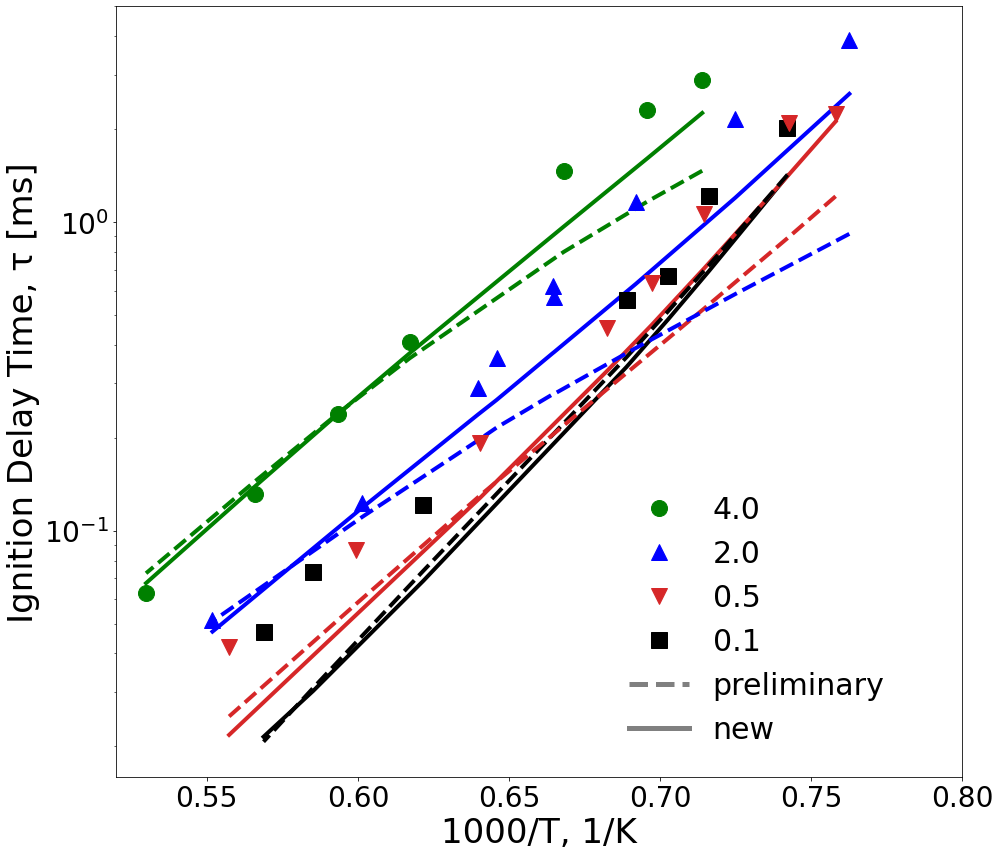

In [9]:
#my model plots


#PLOTTING SECTION
plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['axes.labelsize'] = 34
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'STIX'
#my model
X_list = [0,0.1,0.5,2,4]
colors = [no_CH2F2_color,
'black', #pt1_CH2F2_color,
'tab:red', #pt5_CH2F2_color,
_2_CH2F2_color,
_4_CH2F2_color]

labels = [no_CH2F2_label,
 pt1_CH2F2_label,
pt5_CH2F2_label,
_2_CH2F2_label,
_4_CH2F2_label]

exp_taus = {0: np.array(no_CH2F2_taus),
0.1: np.array(pt1_CH2F2_taus),
0.5: np.array(pt5_CH2F2_taus),
2: np.array(_2_CH2F2_taus),
4: np.array(_4_CH2F2_taus)}

#plot values and calculate RMSE and slopes  
average_slopes = []
for x, color, lbl in zip(X_list, colors, labels):
    if x==0:
        continue
    taus = master_dict[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '-', c=color, label=f'{lbl}, RMG model', markersize=16, linewidth=4) 
        

#plot against originals
for x, color, lbl in zip(X_list, colors, labels):
    if x==0:
        continue
    taus = _98_original[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '--', c=color, label=f'{lbl}, original RMG model', markersize=16, linewidth=4) 
        

        
        
        
        
#experiments

#plt.semilogy(no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_shape, c=no_CH2F2_color, label=no_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_shape, c='black', label=pt1_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_shape, c='tab:red', label=pt5_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_shape, c=_2_CH2F2_color, label=_2_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_shape, c=_4_CH2F2_color, label=_4_CH2F2_label+', experiment', markersize=16) 
plt.ylim(0,5)
#plt.title('', fontsize=26, fontweight="bold")
plt.xlim(0.52,0.8)
plt.xlabel('1000/T, 1/K')
plt.ylabel('Ignition Delay Time, τ [ms]')

legend_elements = [Line2D([0], [0], marker=_4_CH2F2_shape,color=_4_CH2F2_color, lw=0, label='4.0', markersize=16),
                   Line2D([0], [0], marker=_2_CH2F2_shape,color=_2_CH2F2_color, lw=0, label='2.0', markersize=16),
                   Line2D([0], [0], marker=pt5_CH2F2_shape,color='tab:red', lw=0, label='0.5', markersize=16),
                   Line2D([0], [0], marker=pt1_CH2F2_shape,color='black', lw=0, label='0.1', markersize=16),
                   Line2D([0], [0], color='grey', lw=5, label='preliminary',  linestyle='--', ),
                   Line2D([0], [0], color='grey', lw=5, label='new', linestyle='-')]


plt.legend(handles=legend_elements, fontsize=30, bbox_to_anchor=(0.94, 0.4), frameon=False)

plt.show()
    

In [2]:
mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_correct/nuig_brown.yaml'

[1282.4926403839208, 1340.6435048604026, 1346.676056051243, 1467.715829080382, 1517.8555978969807, 1530.3706337301523, 1580.5362399099752, 1604.1551982937947, 1630.6176776501704, 1774.364625755804]
['CH2F2:0, C3H8: 1, O2: 6, Ar:93', 'CH2F2:0.11,C3H8:1.1,O2:6,Ar:92.13', 'CH2F2:0.52,C3H8:1,O2:6,Ar:92.5', 'CH2F2:2,C3H8:1.1,O2:6,Ar:90.9', 'CH2F2:1.99,C3H8:0.5,O2:3,Ar:94.7']
starting 1282.4926403839208 of 0% CH2F2
Initializing reactor network.
Reactor 0: 666 variables.
              0 sensitivity params.
Number of equations: 666
Maximum time step:                0
Max: 0.005487497682217542
mole fractions of OH: [1.83542485e-07 3.24052573e-07 3.72769311e-07 ... 3.59421837e-03
 3.59421838e-03 3.59421839e-03]
slope (a): 54.14926851890742, location of slope (b): 987, y: 0.6422947729671535, x: 4.939999999999883
in the find_id function, found :4.928138440452816
starting 1340.6435048604026 of 0% CH2F2
Initializing reactor network.
Reactor 0: 666 variables.
              0 sensitivity params.
Numbe

/tmp/ipykernel_14058/3386899280.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


starting 1465.1354536041051 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 666 variables.
              0 sensitivity params.
Number of equations: 666
Maximum time step:                0
Max: 0.006200029647759163
mole fractions of OH: [7.76419087e-06 8.74200032e-06 8.96485714e-06 ... 5.11025746e-03
 5.11025913e-03 5.11026079e-03]
slope (a): 58.45024615174671, location of slope (b): 81, y: 0.287724078583946, x: 0.41000000000000075
in the find_id function, found :0.40507745308998494
starting 1561.2448567130064 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 666 variables.
              0 sensitivity params.
Number of equations: 666
Maximum time step:                0
Max: 0.0067075268793467275
mole fractions of OH: [2.72988284e-05 2.79363534e-05 2.79908430e-05 ... 5.78868760e-03
 5.78868776e-03 5.78868793e-03]
slope (a): 66.67767986101819, location of slope (b): 30, y: 0.3334103107749569, x: 0.15500000000000008
in the find_id function, found :0.14999967138223907
starting 1

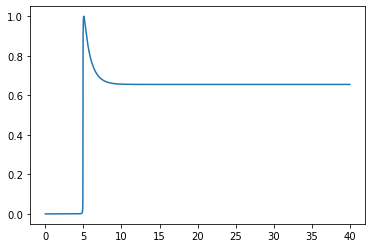

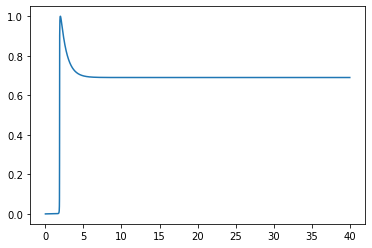

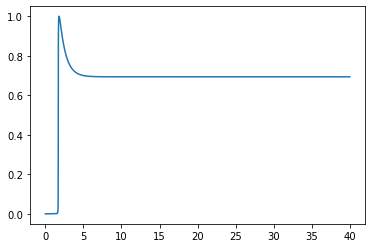

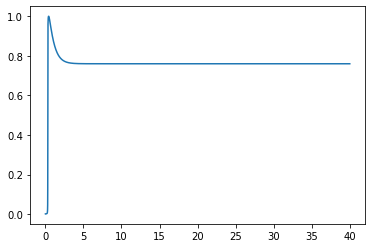

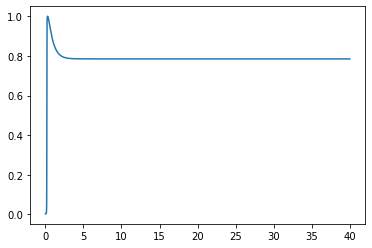

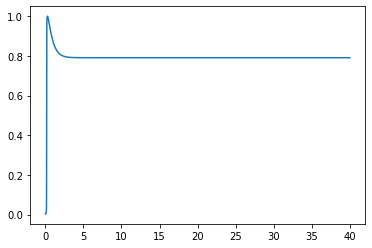

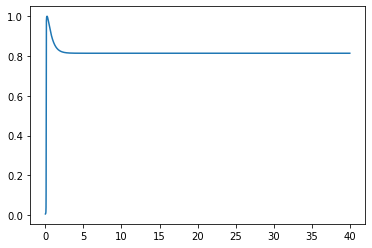

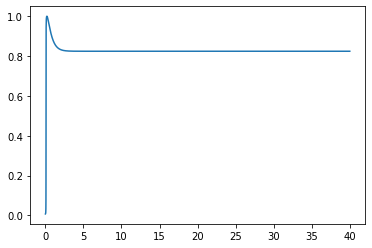

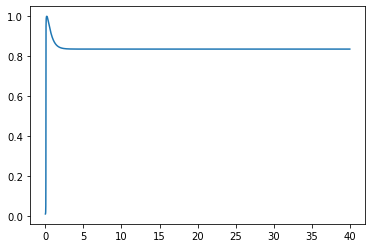

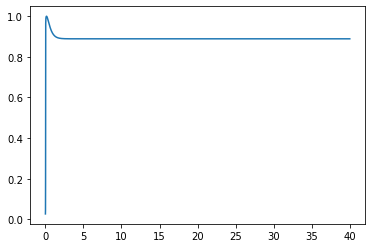

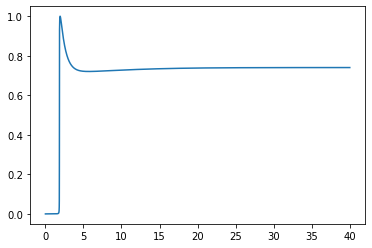

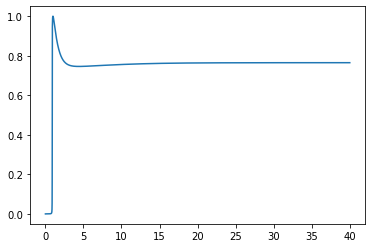

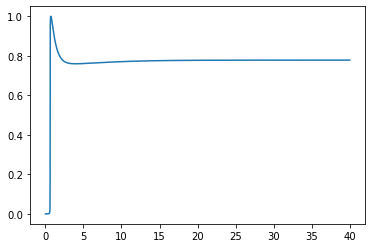

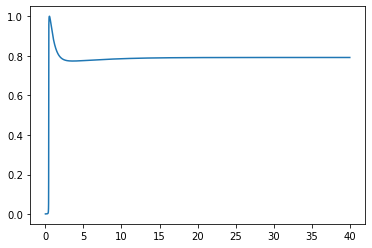

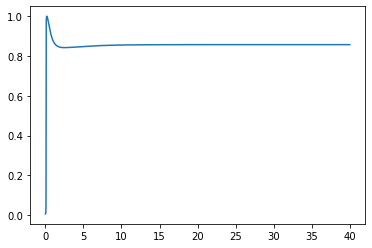

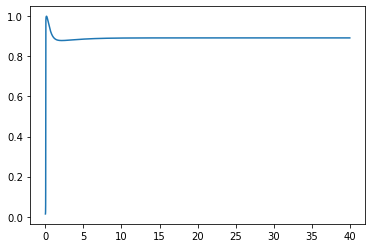

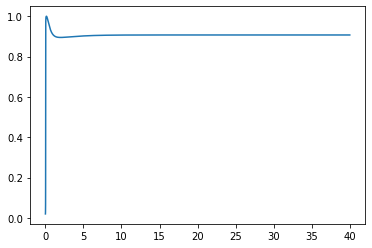

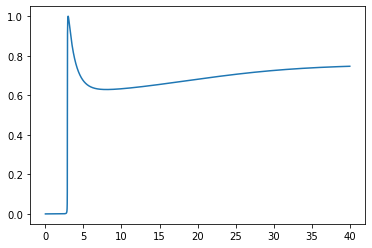

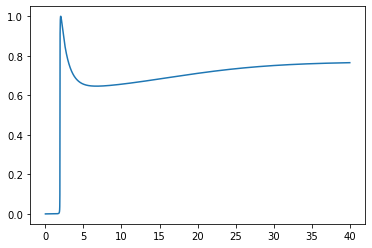

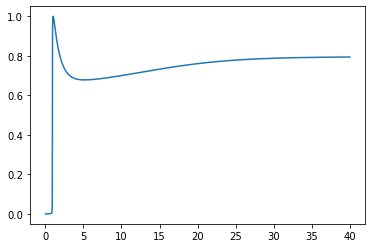

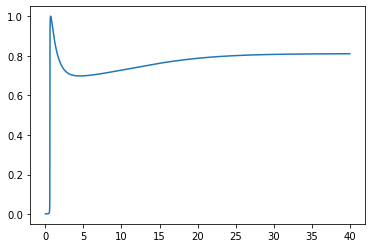

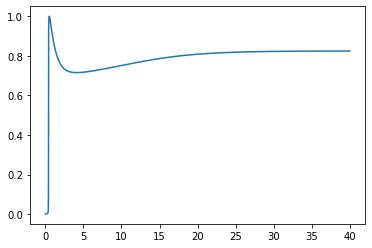

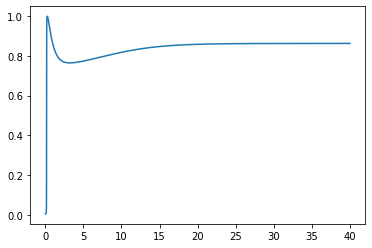

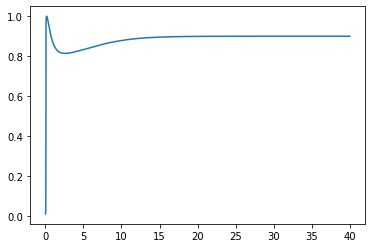

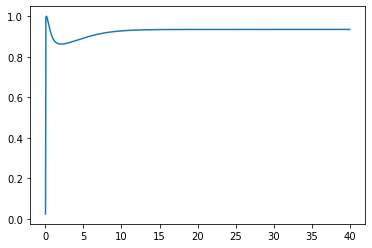

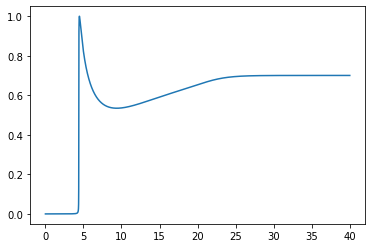

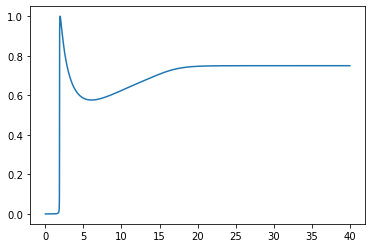

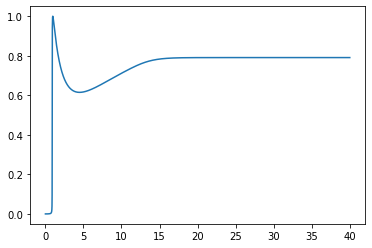

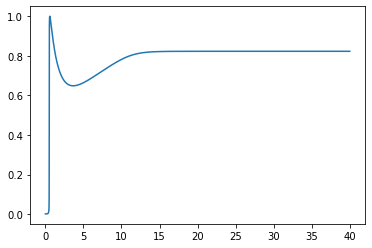

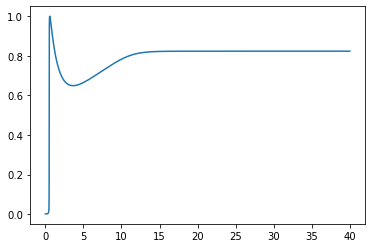

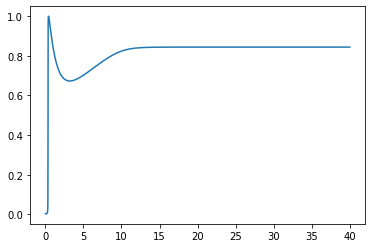

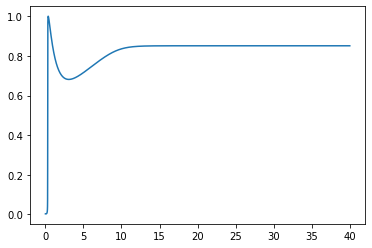

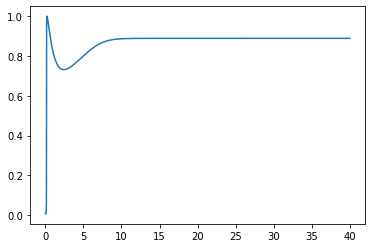

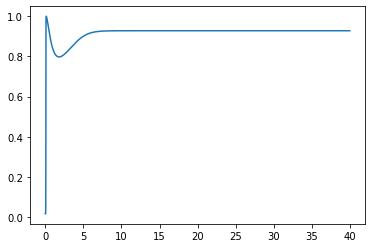

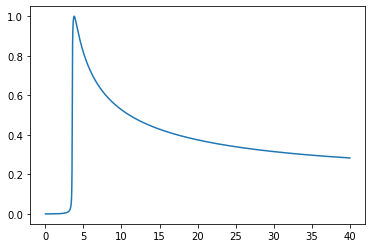

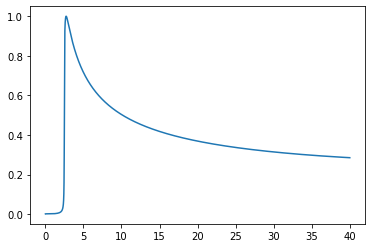

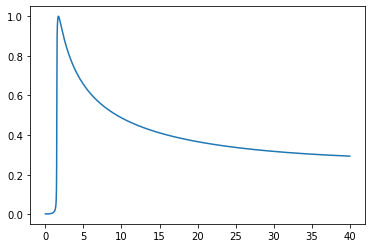

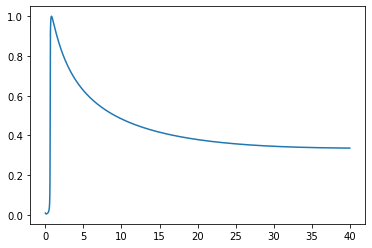

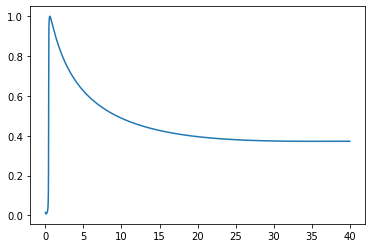

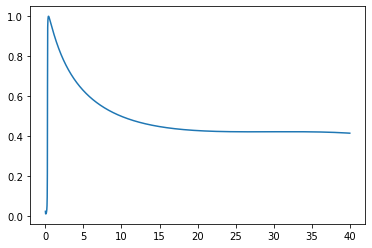

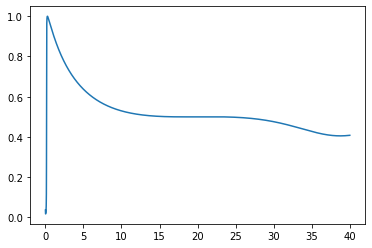

In [7]:
##### doped propane, ANL_brown or NUIG_brown 


#P5_1 = [0.96603599, 1.00671102, 0.95991744, 0.95928503, 0.98402179,
#       1.02082774, 1.02725268] #actual pressures that he measured?
#P5_real = np.mean(P5_1)

specific_temps = {0: temps_for_0,
0.1: temps_for_0_1,
0.5: temps_for_0_5,
2: temps_for_2,
4: temps_for_4}


X_list = [0,0.1,0.5,2,4]
concentrations = ['0','0.1', '0.5', '2', '4']
conc_names = ['CH2F2:0, C3H8: 1, O2: 6, Ar:93','CH2F2:0.11,C3H8:1.1,O2:6,Ar:92.13','CH2F2:0.52,C3H8:1,O2:6,Ar:92.5','CH2F2:2,C3H8:1.1,O2:6,Ar:90.9','CH2F2:1.99,C3H8:0.5,O2:3,Ar:94.7']
 
pressure_dict = {0: 1,  #I'm just assuming this is 1 atm for no CH2F2, there's actually no csv file for it
    0.1:  1.0127232051380075,
    0.5:  1.0158269373681306, 
    2: 1.012855580622881,
    4: 0.9891502432791955}

master_dict={}

for index, x in enumerate(X_list): 

    #mole_frac_dict = {"CH2F2":x, "C3H8": 1, "O2": 5, "AR":94-x} 
    # mole_frac_dict = {"CH2F2":x, "C3H8": 1, "O2": 6, "AR":93-x} 
    
    temps_we_want = specific_temps[x]
    print(temps_we_want)
    
    mole_frac_dict = conc_names[index]
    print(conc_names)
    
    t_id_nuig = np.zeros(len(temps_we_want))
    for i in range(len(temps_we_want)):
        print(f'starting {temps_we_want[i]} of {concentrations[index]}% CH2F2')
            
            
        gas.TPX = temps_we_want[i],pressure_dict[x]*ct.one_atm, mole_frac_dict
        r = ct.Reactor(contents=gas)


        sim = ct.ReactorNet([r])
        sim.verbose = True

        states = ct.SolutionArray(gas, extra=['t'])
        
        dt_max = 5e-6
        t_end = (2000 * dt_max)*4

        while sim.time < t_end:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time*1e3)
            
        print(f"Max: {np.max(states.X[:, gas.species_index('OH')])}")
        print(f"mole fractions of OH: {states.X[:, gas.species_index('OH')]}")
        
        diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH')]/np.max(states.X[:, gas.species_index('OH')]))
        t_id_nuig[i] = t_id #id in ms
        
        plt.figure()
        plt.plot(states.t,states.X[:, gas.species_index('OH')]/np.max(states.X[:, gas.species_index('OH')]))
#     #save the data   
    master_dict[x] = t_id_nuig

    

/tmp/ipykernel_10442/13788929.py:74: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,5)


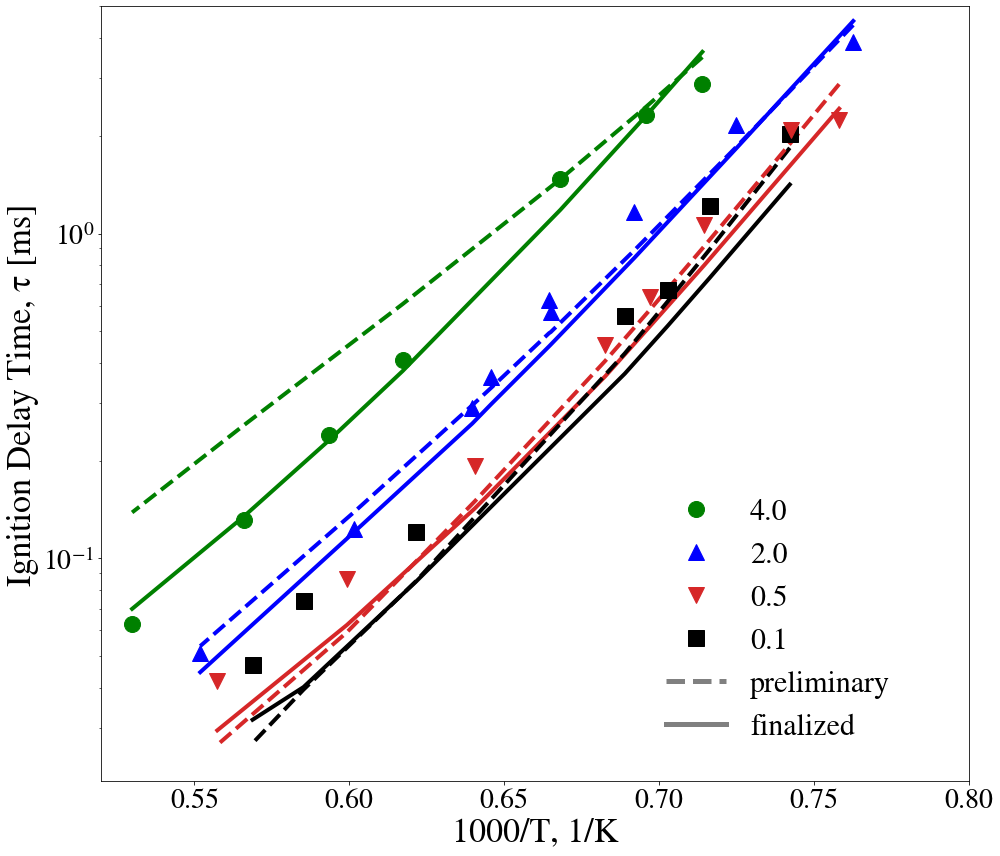

In [17]:
#my model plots


#PLOTTING SECTION
plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['axes.labelsize'] = 34
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'STIX'
#my model
X_list = [0,0.1,0.5,2,4]
colors = [no_CH2F2_color,
'black', #pt1_CH2F2_color,
'tab:red', #pt5_CH2F2_color,
_2_CH2F2_color,
_4_CH2F2_color]

labels = [no_CH2F2_label,
 pt1_CH2F2_label,
pt5_CH2F2_label,
_2_CH2F2_label,
_4_CH2F2_label]

exp_taus = {0: np.array(no_CH2F2_taus),
0.1: np.array(pt1_CH2F2_taus),
0.5: np.array(pt5_CH2F2_taus),
2: np.array(_2_CH2F2_taus),
4: np.array(_4_CH2F2_taus)}

#plot values and calculate RMSE and slopes  
average_slopes = []
for x, color, lbl in zip(X_list, colors, labels):
    if x==0:
        continue
    taus = master_dict[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '-', c=color, label=f'{lbl}, RMG model', markersize=16, linewidth=4) 
        
        
nuig_brown_original = {0: np.array([4.92813844, 1.8541225 , 1.68278931, 0.31023078, 0.17421458,
        0.15511094, 0.09588006, 0.07691934, 0.06111107, 0.02033671]),
 0.1: np.array([1.83447058, 0.89266688, 0.61803463, 0.42746894, 0.08532181,
        0.03945492, 0.02698942]),
 0.5: np.array([2.88173334, 1.90818878, 0.9141826 , 0.58458101, 0.40507745,
        0.14999967, 0.05926122, 0.02666096]),
 2: np.array([4.38173071, 1.84787971, 0.88742464, 0.49735244, 0.49376781,
        0.33575077, 0.29607187, 0.1386858 , 0.05372001]),
 4: np.array([3.48956179, 2.45542772, 1.47008838, 0.60634457, 0.40748898,
        0.25660269, 0.13849756])}

#plot against originals
for x, color, lbl in zip(X_list, colors, labels):
    if x==0:
        continue
    taus = nuig_brown_original[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '--', c=color, label=f'{lbl}, original RMG model', markersize=16, linewidth=4) 
        

        
        
        
        
#experiments

#plt.semilogy(no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_shape, c=no_CH2F2_color, label=no_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_shape, c='black', label=pt1_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_shape, c='tab:red', label=pt5_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_shape, c=_2_CH2F2_color, label=_2_CH2F2_label+', experiment', markersize=16) 
plt.semilogy(_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_shape, c=_4_CH2F2_color, label=_4_CH2F2_label+', experiment', markersize=16) 
plt.ylim(0,5)
#plt.title('', fontsize=26, fontweight="bold")
plt.xlim(0.52,0.8)
plt.xlabel('1000/T, 1/K')
plt.ylabel('Ignition Delay Time, τ [ms]')

legend_elements = [Line2D([0], [0], marker=_4_CH2F2_shape,color=_4_CH2F2_color, lw=0, label='4.0', markersize=16),
                   Line2D([0], [0], marker=_2_CH2F2_shape,color=_2_CH2F2_color, lw=0, label='2.0', markersize=16),
                   Line2D([0], [0], marker=pt5_CH2F2_shape,color='tab:red', lw=0, label='0.5', markersize=16),
                   Line2D([0], [0], marker=pt1_CH2F2_shape,color='black', lw=0, label='0.1', markersize=16),
                   Line2D([0], [0], color='grey', lw=5, label='preliminary',  linestyle='--', ),
                   Line2D([0], [0], color='grey', lw=5, label='finalized', linestyle='-')]


plt.legend(handles=legend_elements, fontsize=30, bbox_to_anchor=(0.94, 0.4), frameon=False)

plt.show()
    

In [10]:
#NUIG_brown 
master_dict

{0: array([4.92813844, 1.8541225 , 1.68278931, 0.31023078, 0.17421458,
        0.15511094, 0.09588006, 0.07691934, 0.06111107, 0.02033671]),
 0.1: array([1.83447058, 0.89266688, 0.61803463, 0.42746894, 0.08532181,
        0.03945492, 0.02698942]),
 0.5: array([2.88173334, 1.90818878, 0.9141826 , 0.58458101, 0.40507745,
        0.14999967, 0.05926122, 0.02666096]),
 2: array([4.38173071, 1.84787971, 0.88742464, 0.49735244, 0.49376781,
        0.33575077, 0.29607187, 0.1386858 , 0.05372001]),
 4: array([3.48956179, 2.45542772, 1.47008838, 0.60634457, 0.40748898,
        0.25660269, 0.13849756])}

In [41]:
#THIS IS ANL_BURGESS DATA, DO NOT TOUCH


master_dict #ANL_Burgess

{0: array([3.3451225 , 1.39578107, 1.27774073, 0.27463596, 0.16451499,
        0.14362281, 0.09486718, 0.07817588, 0.06461476, 0.02606464]),
 0.1: array([1.34008377, 0.69347081, 0.49562972, 0.35429842, 0.07997028,
        0.04165868, 0.03105328]),
 0.5: array([1.89514549, 1.28714687, 0.64503007, 0.42517263, 0.30217603,
        0.12071657, 0.05498783, 0.02571416]),
 2: array([2.28896518, 0.95581801, 0.44941537, 0.24611012, 0.24511845,
        0.16509001, 0.14509005, 0.06472932, 0.02638783]),
 4: array([1.47533366, 0.96157944, 0.5087646 , 0.16875437, 0.10281648,
        0.05886224, 0.02842532])}

In [9]:
#doping data, eduardos experiments 

no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_label, no_CH2F2_color, no_CH2F2_shape  = [[0.63269666, 0.56358202, 0.61326454, 0.62338108, 0.6588242,  0.74256908,
 0.77973157, 0.74591045, 0.65343648, 0.6813308], 
 [0.140397, 0.03592654, 0.08382547, 0.1015549,  0.21059732, 1.74050565,
 3.16531584, 1.67252058, 0.19990897, 0.36081361], '0% CH$_2$F$_2$', 'k', 's']
                                                                      
                    
pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_label, pt1_CH2F2_color,  pt1_CH2F2_shape =[[0.71625797, 0.56876523, 0.58520137, 0.6216291, 0.70274495, 0.68888998,
 0.74213088], 
 [1.21382961, 0.0471075,  0.07372893, 0.12092486, 0.67064511, 0.55730096,
 2.02355779], '0.1% CH$_2$F$_2$', 'm', 's']
                                                          
    
pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_label, pt5_CH2F2_color,  pt5_CH2F2_shape  = [[0.64051452, 0.74256407, 0.75806182, 0.59921964, 0.55737473, 0.69714701,
 0.71456021, 0.68253075], 
 [0.19242997, 2.08706923, 2.24174715, 0.08639935, 0.04194953, 0.63637152,
 1.06022888, 0.4540505 ], '0.5% CH$_2$F$_2$', 'c', 'v'] 

_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_label, _2_CH2F2_color,  _2_CH2F2_shape = [[0.6014515, 0.72489571, 0.76260487, 0.63965302, 0.64586785, 0.66499352,
 0.66447004, 0.69194404, 0.55187601], 
 [0.12278134, 2.15618223, 3.8948634,  0.28953096, 0.36193926, 0.57132118,
 0.62294087, 1.16312355, 0.051226],  '2% CH$_2$F$_2$', 'b', '^']

_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_label, _4_CH2F2_color,  _4_CH2F2_shape = [[0.59342286, 0.56586408, 0.61717534, 0.66810691, 0.69578168, 0.71392225,
 0.52988636], 
 [0.2396125, 0.13106904, 0.40859232, 1.46789449, 2.3113845,  2.8922329,
 0.06264836], '4% CH$_2$F$_2$', 'g', 'o']


temps_for_0 = sorted([1000/T_inv for T_inv in no_CH2F2_temps_inv])
temps_for_0_1 = sorted([1000/T_inv for T_inv in pt1_CH2F2_temps_inv])
temps_for_0_5 = sorted([1000/T_inv for T_inv in pt5_CH2F2_temps_inv])
temps_for_2 = sorted([1000/T_inv for T_inv in _2_CH2F2_temps_inv])
temps_for_4 = sorted([1000/T_inv for T_inv in _4_CH2F2_temps_inv])

/tmp/ipykernel_137422/2657874723.py:86: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,10)


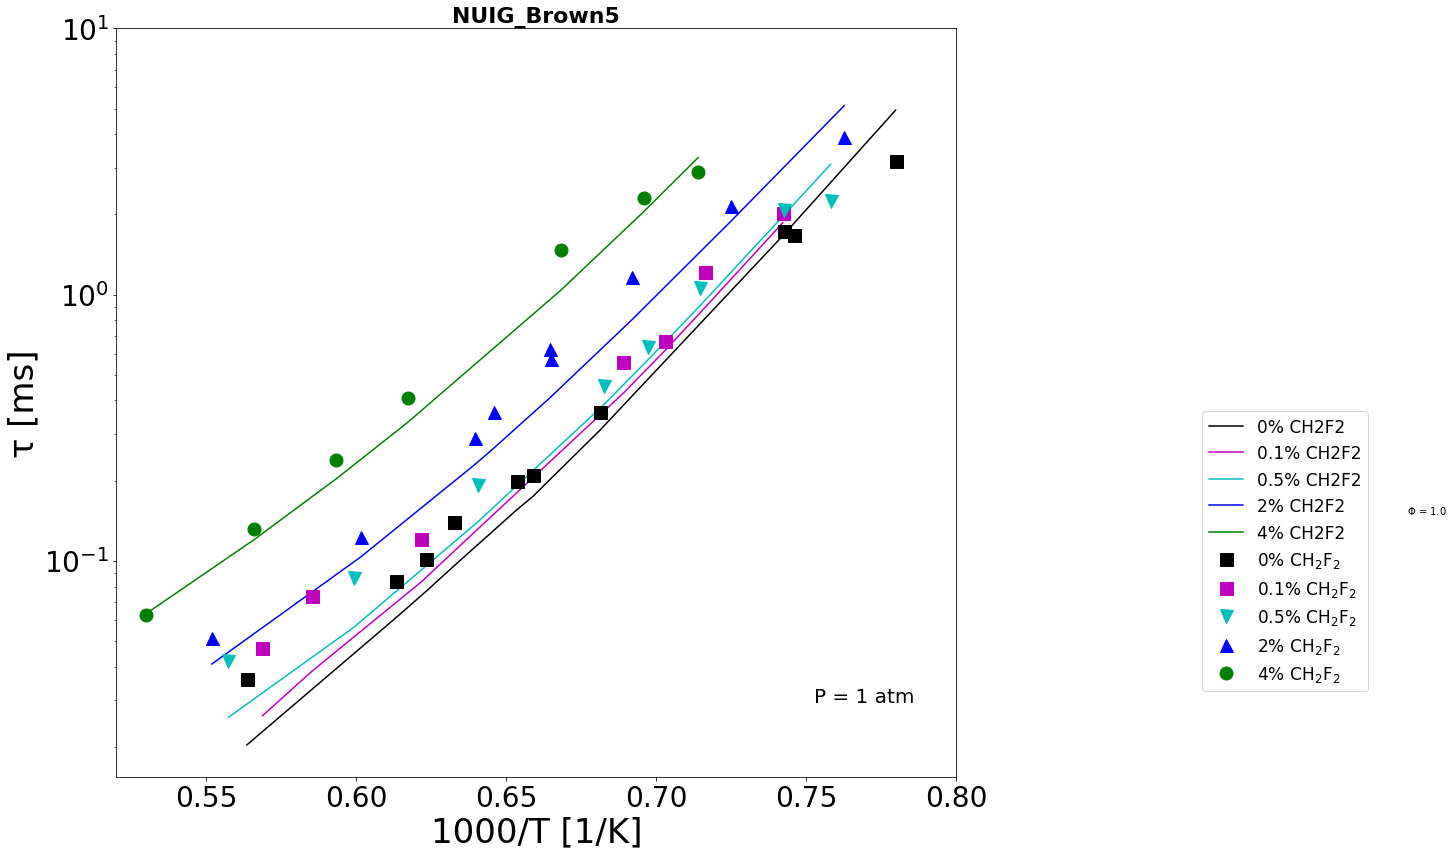

In [9]:
#doping data, eduardos experiments , ONLY PROPANE

                                             
#PLOTTING SECTION
plt.rcParams['figure.figsize'] = (24, 12)
plt.rcParams['axes.labelsize'] = 34
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'Times New Roman'

#my model
X_list = [0,0.1,0.5,2,4]
colors = [no_CH2F2_color,
pt1_CH2F2_color,
pt5_CH2F2_color,
_2_CH2F2_color,
_4_CH2F2_color]

# X_list = [0]
# colors = [no_CH2F2_color]

exp_taus = {0: np.array(no_CH2F2_taus),
0.1: np.array(pt1_CH2F2_taus),
0.5: np.array(pt5_CH2F2_taus),
2: np.array(_2_CH2F2_taus),
4: np.array(_4_CH2F2_taus)}

#to save RMSE values for each line
RMSEs = {}


#plot values and calculate RMSE and slopes  
average_slopes = []
for x, color in zip(X_list, colors):
    taus = master_dict[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    exp_values = exp_taus[x]
    
    #RMSE
    n = len(exp_values) 
    y_hat = taus_to_plot
    y = exp_values
    RMSE = np.sqrt((1/n) * sum(np.square(y - y_hat)))
    RMSEs[x] = RMSE
    
    #slope differences 
    temps_to_plot = [1000/T for T in specific_temps[x]]
    
    #average_slope = get_average_slope(taus_to_plot, temps_to_plot) 
    #average_slopes.append(average_slope)
    
 
    #temps_to_plot = T5_inverse[0:len(taus_to_plot)]
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '-', c=color, label=f'{x}% CH2F2', markersize=16) 

#compare the slopes
#slope_comparison = compare_slopes(average_slopes, average_slopes[-1])

#plot ANL_Burgess data
ANL_Burgess_data = {0: np.array([3.3451225 , 1.39578107, 1.27774073, 0.27463596, 0.16451499,
        0.14362281, 0.09486718, 0.07817588, 0.06461476, 0.02606464]),
 0.1: np.array([1.34008377, 0.69347081, 0.49562972, 0.35429842, 0.07997028,
        0.04165868, 0.03105328]),
 0.5: np.array([1.89514549, 1.28714687, 0.64503007, 0.42517263, 0.30217603,
        0.12071657, 0.05498783, 0.02571416]),
 2: np.array([2.28896518, 0.95581801, 0.44941537, 0.24611012, 0.24511845,
        0.16509001, 0.14509005, 0.06472932, 0.02638783]),
 4: np.array([1.47533366, 0.96157944, 0.5087646 , 0.16875437, 0.10281648,
        0.05886224, 0.02842532])}

for x, color in zip(X_list, colors):
    ANL_Burgess_taus = ANL_Burgess_data [x]
    ANL_Burgess_taus_to_plot = np.array(ANL_Burgess_taus)#[tau for tau in taus if tau>0])
    
    #plt.semilogy([1000/T for T in specific_temps[x]], ANL_Burgess_taus_to_plot, ':', c=color, label=f'{x}% CH2F2, ANL_Burgess', markersize=16) 



#experiments
plt.semilogy(no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_shape, c=no_CH2F2_color, label=no_CH2F2_label, markersize=13) 
plt.semilogy(pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_shape, c=pt1_CH2F2_color, label=pt1_CH2F2_label, markersize=13) 
plt.semilogy(pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_shape, c=pt5_CH2F2_color, label=pt5_CH2F2_label, markersize=13) 
plt.semilogy(_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_shape, c=_2_CH2F2_color, label=_2_CH2F2_label, markersize=13) 
plt.semilogy(_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_shape, c=_4_CH2F2_color, label=_4_CH2F2_label, markersize=13) 
plt.ylim(0,10)
plt.xlim(0.52,0.8)
plt.xlabel('1000/T [1/K]')
plt.ylabel('τ [ms]')
plt.legend(fontsize=17, bbox_to_anchor=(1.5, 0.5))
#plt.text(0.95, 0.05, r'$\mathrm{C2H8:1, O2:6, Ar:93}$', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.10, 'P = 1 atm', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
# plt.text(0.95,1, f'RMSE\n{RMSEs[0]}\n{RMSEs[0.1]}\n{RMSEs[0.5]}\n{RMSEs[2]}\n{RMSEs[4]}\n{RMSEs[4]}')#, transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
# plt.text(0.85,1, f'Slope Comparison: {slope_comparison}')# transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.15, '$\Phi$ = 1.0')#  transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)


#calculate RMSE 

plt.title('NUIG_Brown5', fontsize = 22, fontweight='bold')


plt.show()
    

In [10]:
master_dict#NUIG_Brown5 data

{0: array([4.9281383 , 1.85412256, 1.68278923, 0.31023077, 0.17421458,
        0.15511095, 0.09588007, 0.07691934, 0.06111107, 0.02033671]),
 0.1: array([1.86040357, 0.89477547, 0.61369292, 0.42478481, 0.08318001,
        0.03840973, 0.02615942]),
 0.5: array([3.08650128, 1.99065813, 0.90794858, 0.56743361, 0.38599164,
        0.13990525, 0.05623781, 0.0257804 ]),
 2: array([5.12353371, 1.88767803, 0.80548453, 0.41406095, 0.40873166,
        0.26503176, 0.23044622, 0.10320849, 0.04091112]),
 4: array([3.26746218, 2.04759372, 1.03637033, 0.33117564, 0.20345969,
        0.11975965, 0.06315196])}

In [12]:
master_dict #ANL_Brown5 data

{0: array([3.34512244, 1.39578106, 1.27774073, 0.27463596, 0.16451499,
        0.14362282, 0.09486718, 0.07817588, 0.06461476, 0.02606464]),
 0.1: array([1.41470325, 0.72975247, 0.51979271, 0.37035585, 0.08505278,
        0.04017623, 0.03187427]),
 0.5: array([2.42194955, 1.63205241, 0.79943987, 0.51992003, 0.36317716,
        0.14261128, 0.06240889, 0.02956604]),
 2: array([4.50747973, 1.82971305, 0.84061001, 0.45499844, 0.4496796 ,
        0.29906937, 0.26000075, 0.12032136, 0.04464724]),
 4: array([3.6222038 , 2.30479099, 1.18294366, 0.37716212, 0.23086278,
        0.13439255, 0.06993766])}

/tmp/ipykernel_1521/728109031.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,10)


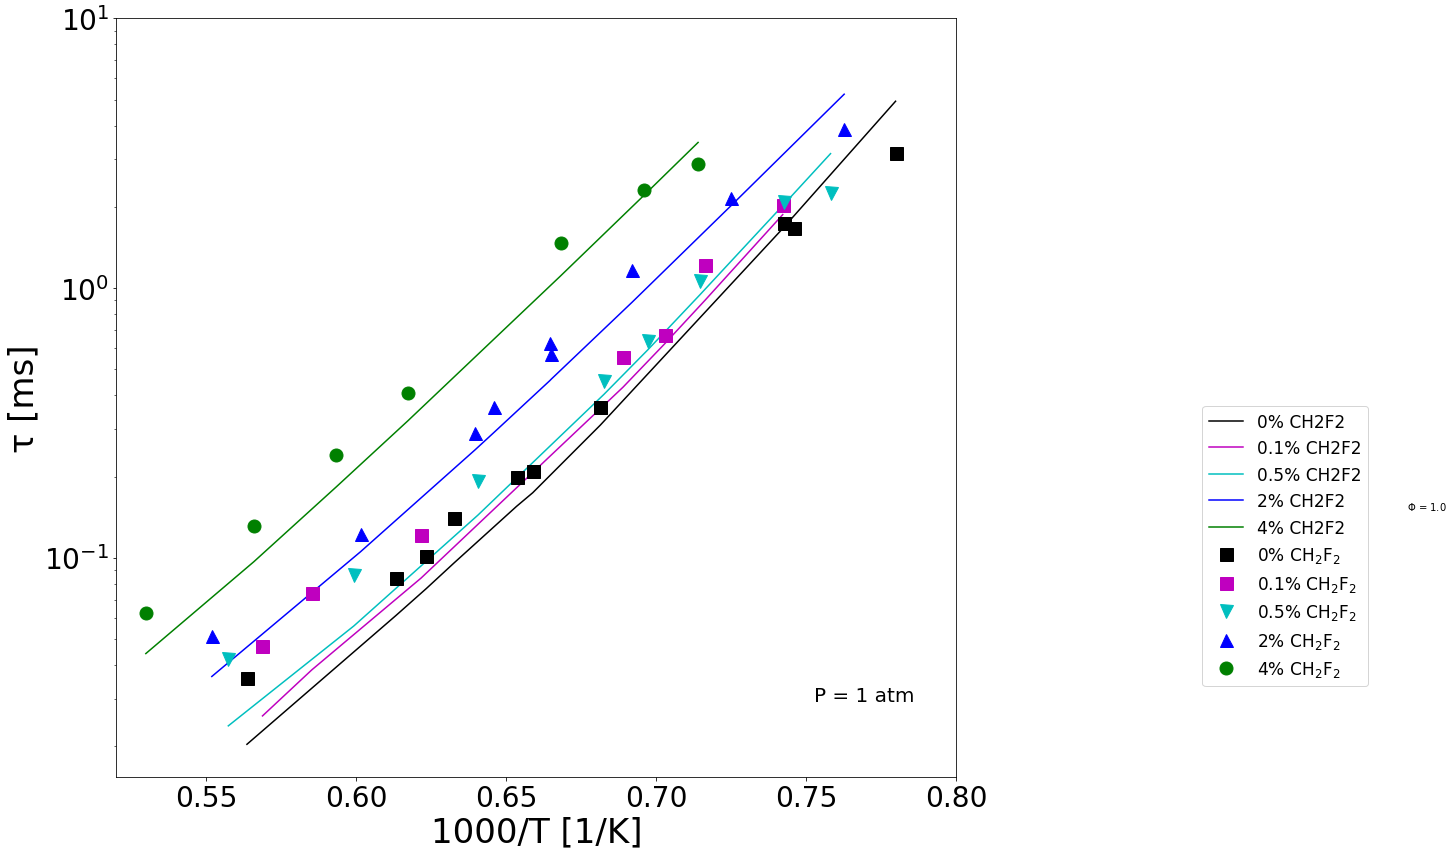

In [18]:
#doping data, eduardos experiments , ONLY PROPANE

                                             
#PLOTTING SECTION
plt.rcParams['figure.figsize'] = (24, 12)
plt.rcParams['axes.labelsize'] = 34
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'Times New Roman'

#my model
X_list = [0,0.1,0.5,2,4]
colors = [no_CH2F2_color,
pt1_CH2F2_color,
pt5_CH2F2_color,
_2_CH2F2_color,
_4_CH2F2_color]

# X_list = [0]
# colors = [no_CH2F2_color]

exp_taus = {0: np.array(no_CH2F2_taus),
0.1: np.array(pt1_CH2F2_taus),
0.5: np.array(pt5_CH2F2_taus),
2: np.array(_2_CH2F2_taus),
4: np.array(_4_CH2F2_taus)}

#to save RMSE values for each line
RMSEs = {}


#plot values and calculate RMSE and slopes  
average_slopes = []
for x, color in zip(X_list, colors):
    taus = master_dict[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    exp_values = exp_taus[x]
    
    #RMSE
    n = len(exp_values) 
    y_hat = taus_to_plot
    y = exp_values
    RMSE = np.sqrt((1/n) * sum(np.square(y - y_hat)))
    RMSEs[x] = RMSE
    
    #slope differences 
    temps_to_plot = [1000/T for T in specific_temps[x]]
    
    #average_slope = get_average_slope(taus_to_plot, temps_to_plot) 
    #average_slopes.append(average_slope)
    
 
    #temps_to_plot = T5_inverse[0:len(taus_to_plot)]
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '-', c=color, label=f'{x}% CH2F2', markersize=16) 

#compare the slopes
#slope_comparison = compare_slopes(average_slopes, average_slopes[-1])


#experiments
plt.semilogy(no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_shape, c=no_CH2F2_color, label=no_CH2F2_label, markersize=13) 
plt.semilogy(pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_shape, c=pt1_CH2F2_color, label=pt1_CH2F2_label, markersize=13) 
plt.semilogy(pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_shape, c=pt5_CH2F2_color, label=pt5_CH2F2_label, markersize=13) 
plt.semilogy(_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_shape, c=_2_CH2F2_color, label=_2_CH2F2_label, markersize=13) 
plt.semilogy(_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_shape, c=_4_CH2F2_color, label=_4_CH2F2_label, markersize=13) 
plt.ylim(0,10)
plt.xlim(0.52,0.8)
plt.xlabel('1000/T [1/K]')
plt.ylabel('τ [ms]')
plt.legend(fontsize=17, bbox_to_anchor=(1.5, 0.5))
#plt.text(0.95, 0.05, r'$\mathrm{C2H8:1, O2:6, Ar:93}$', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.10, 'P = 1 atm', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
# plt.text(0.95,1, f'RMSE\n{RMSEs[0]}\n{RMSEs[0.1]}\n{RMSEs[0.5]}\n{RMSEs[2]}\n{RMSEs[4]}\n{RMSEs[4]}')#, transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
# plt.text(0.85,1, f'Slope Comparison: {slope_comparison}')# transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.15, '$\Phi$ = 1.0')#  transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)


#calculate RMSE 




plt.show()
    

In [ ]:
master_dict

In [ ]:
#all sens rxns in NUIG_Brown yaml 

In [ ]:
master_dict = {0: np.array([4.94187583, 1.80276683, 1.67403756, 0.27884569, 0.17011191,
       0.12497179, 0.08765146, 0.0762272 , 0.05685305, 0.0208889 ]), 0.1: np.array([1.83751906, 0.88009723, 0.61165121, 0.39925828, 0.08396583,
       0.04042022, 0.02815661]), 0.5: np.array([2.95252717, 1.94420537, 0.84972792, 0.56944061, 0.39101745,
       0.14026824, 0.05261148, 0.02411433]), 2: np.array([5.39928683, 2.03776077, 0.89427434, 0.4709102 , 0.46763789,
       0.289528  , 0.26915926, 0.11923566, 0.05027419]), 4: np.array([5.8185413 , 3.69551051, 1.89924086, 0.62020515, 0.38136223,
       0.22777846, 0.11767793])}

In [ ]:
#doping data, eduardos experiments , ONLY PROPANE

                                             
#PLOTTING SECTION
plt.rcParams['figure.figsize'] = (24, 12)
plt.rcParams['axes.labelsize'] = 34
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'Times New Roman'

#my model
X_list = [0,0.1,0.5,2,4]
colors = [no_CH2F2_color,
pt1_CH2F2_color,
pt5_CH2F2_color,
_2_CH2F2_color,
_4_CH2F2_color]


exp_taus = {0: np.array(no_CH2F2_taus),
0.1: np.array(pt1_CH2F2_taus),
0.5: np.array(pt5_CH2F2_taus),
2: np.array(_2_CH2F2_taus),
4: np.array(_4_CH2F2_taus)}

#to save RMSE values for each line
RMSEs = {}


#plot values and calculate RMSE and slopes  
average_slopes = []
for x, color in zip(X_list, colors):
    taus = master_dict[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    exp_values = exp_taus[x]
    
    #RMSE
    n = len(exp_values) 
    y_hat = taus_to_plot
    y = exp_values
    RMSE = np.sqrt((1/n) * sum(np.square(y - y_hat)))
    RMSEs[x] = RMSE
    
    #slope differences 
    temps_to_plot = [1000/T for T in specific_temps[x]]
    
    average_slope = get_average_slope(taus_to_plot, temps_to_plot) 
    average_slopes.append(average_slope)
    
 
    #temps_to_plot = T5_inverse[0:len(taus_to_plot)]
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '-', c=color, label=f'{x}% CH2F2', markersize=16) 

#compare the slopes
slope_comparison = compare_slopes(average_slopes, average_slopes[-1])


#experiments
plt.semilogy(no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_shape, c=no_CH2F2_color, label=no_CH2F2_label, markersize=13) 
plt.semilogy(pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_shape, c=pt1_CH2F2_color, label=pt1_CH2F2_label, markersize=13) 
plt.semilogy(pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_shape, c=pt5_CH2F2_color, label=pt5_CH2F2_label, markersize=13) 
plt.semilogy(_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_shape, c=_2_CH2F2_color, label=_2_CH2F2_label, markersize=13) 
plt.semilogy(_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_shape, c=_4_CH2F2_color, label=_4_CH2F2_label, markersize=13) 
plt.ylim(0,10)
plt.xlim(0.52,0.8)
plt.xlabel('1000/T [1/K]')
plt.ylabel('τ [ms]')
plt.legend(fontsize=17, bbox_to_anchor=(1.5, 0.5))
#plt.text(0.95, 0.05, r'$\mathrm{C2H8:1, O2:6, Ar:93}$', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.10, 'P = 1 atm', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95,1, f'RMSE\n{RMSEs[0]}\n{RMSEs[0.1]}\n{RMSEs[0.5]}\n{RMSEs[2]}\n{RMSEs[4]}\n{RMSEs[4]}')#, transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.85,1, f'Slope Comparison: {slope_comparison}')# transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.15, '$\Phi$ = 1.0')#  transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)


#calculate RMSE 




plt.show()
    

## If we don't want to change the yaml file manually, we can just do it all in cantera like in the automated script

In [28]:
import cantera as ct
import numpy as np
import time
import pandas as pd
import os 
import re
import itertools
import sys 
import json
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
import os 
%matplotlib inline


print('This file was created by NK on Oct 18, 2023')
print('Runnning Cantera version: ' + ct.__version__)

This file was created by NK on Oct 18, 2023
Runnning Cantera version: 2.5.1


In [30]:
#load the RMG gas solution object 
path_to_RMG = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/second_try_on_rebase/chemkin/copies/copy_91_chem_annotated-franklins-edits.cti'
RMG_gas = ct.Solution(path_to_RMG)

In [31]:
########### load the abbreviated version of the NUIG_Brown gas solution object ###############
#mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_kinetics_flipped/anl_brown_flipping/ANL_brown3_template.yaml'
#mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_kinetics_flipped/anl_brown_flipping/ANL_brown3_template_remove_swap_to_RMG_kinetics.yaml'
#mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_kinetics_flipped/anl_brown_flipping/ANL_brown3_template_remove_341.yaml'
mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8_CH2F2/eduardos_kinetics_flipped/anl_brown_flipping/ANL_brown3_template-uncommented.yaml'
gas_full=ct.Solution(mechfile)

# use this toggle to use either the full mechanism (True) or a smaller version (False)
FullMech = False
#FullMech = True

if FullMech==False:
    
    #exclude = ['CH2CCHCH2CHCH2'] #add specific species here. (for illustration purposes, since the Max_N_oxygen below would eliminate it anyway)
    max_N_carbon = 4
    max_N_oxygen = 3
    
    all_species = ct.Species.listFromFile(mechfile)
    species = []
    # Filter species
    for S in all_species:
#         if S.name in exclude:
#             print( "excluding %s"%(S.name) )
#             continue #skip this species
        comp = S.composition
        if S.name in ['C6H9', 'C6H10']:
            continue
        if 'C' in comp and comp['C']> max_N_carbon:
            print( "excluding %s"%(S.name) )
            continue
        if 'O' in comp and comp['O']> max_N_oxygen:
            print( "excluding %s"%(S.name) )
            continue            
#         if 'He' in comp: # Exclude Helium
#             print( "excluding %s"%(S.name) )
#             continue
#         if 'Ar' in comp: # Exclude Argon
#             print( "excluding %s"%(S.name) )
#             continue
#         if 'Kr' in comp: # Exclude Krypton
#             print( "excluding %s"%(S.name) )
#             continue   
        #print S.name    
        species.append(S)

    species_names = {S.name for S in species}
    # Filter reactions, keeping only those that only involve the selected species
    all_reactions = gas_full.reactions()
    reactions = []

    for R in all_reactions:
        if not all(reactant in species_names for reactant in R.reactants):
            continue
        if not all(product in species_names for product in R.products):
            continue
        reactions.append(R)
    

    gas_small = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)
    N_B_gas = gas_small    
else:
    N_B_gas = gas_full

print( "final ANL_Brown mechanism has %d species and %d reactions"%(N_B_gas.n_species, N_B_gas.n_reactions) )

#############################################

excluding CH3CH(OO)CH2OOH
excluding CH3CH(OOH)CH2OO
excluding OHOCH2CH2CH2OO
excluding CH2CH(OOH)CH2OOH
excluding C5H2
excluding H2CCCCCH
excluding HCCCHCCH
excluding C5H4
excluding C5H5
excluding C5H5(L)
excluding C5H6
excluding C6H2
excluding C6H4
excluding C6H5
excluding C6H6
excluding C4H5C2H
excluding FULVENE
excluding CHCCH2CHCCH2
excluding CH2CHCHCHCCH
excluding C6H7
excluding C5H4O
excluding C6H813
excluding C6H814
excluding CH2CCHCH2CHCH2
excluding CHCCH2CH2CHCH2
excluding C5H4OH
excluding C5H5O
excluding C6H5O
excluding C6H5OH
excluding C6H3O2
excluding PC6H4O2
excluding OC6H4O2
excluding C6H3O3
final ANL_Brown mechanism has 248 species and 1199 reactions


Before addition: 1199
adding in CH3 + CHF2CHF2 <=> CH4 + CHF2CF2 from RMG
adding in CHF2 + HO2 <=> CH2F2 + O2 from RMG
adding in C2H3 + CH2F2 <=> C2H4 + CHF2 from RMG
adding in CHF2CHF2 + H <=> CHF2CF2 + H2 from RMG
adding in CHF + O2 <=> CFO2 + H from RMG
adding in CHF2 + HCO <=> CH2F2 + CO from RMG
adding in CHF2 + FCCF <=> CF2 + CHFCF from RMG
adding in CH2 + CH2F2 <=> CH3 + CHF2 from RMG
After addition: 1207
[1282.4926403839208, 1340.6435048604026, 1346.676056051243, 1467.715829080382, 1517.8555978969807, 1530.3706337301523, 1580.5362399099752, 1604.1551982937947, 1630.6176776501704, 1774.364625755804]
['CH2F2:0, C3H8: 1, O2: 6, Ar:93', 'CH2F2:0.11,C3H8:1.1,O2:6,Ar:92.13', 'CH2F2:0.52,C3H8:1,O2:6,Ar:92.5', 'CH2F2:2,C3H8:1.1,O2:6,Ar:90.9', 'CH2F2:1.99,C3H8:0.5,O2:3,Ar:94.7']
starting 1282.4926403839208 of 0% CH2F2
Initializing reactor network.
Reactor 0: 251 variables.
              0 sensitivity params.
Number of equations: 251
Maximum time step:                0
Max: 0.00541699102

/tmp/ipykernel_22477/142041609.py:302: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Max: 0.006219801187854562
mole fractions of OH: [8.90864665e-06 1.05736484e-05 1.15372180e-05 ... 4.78991857e-03
 4.78992483e-03 4.78993109e-03]
slope (a): 65.70949424432334, location of slope (b): 72, y: 0.3376099751937282, x: 0.36500000000000066
in the find_id function, found :0.35986208227477184
starting 1561.2448567130064 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 251 variables.
              0 sensitivity params.
Number of equations: 251
Maximum time step:                0
Max: 0.006723700876149585
mole fractions of OH: [3.18659240e-05 3.50595543e-05 3.66197377e-05 ... 5.50709327e-03
 5.50709994e-03 5.50710661e-03]
slope (a): 70.90886115651051, location of slope (b): 28, y: 0.5588367978500304, x: 0.14500000000000005
in the find_id function, found :0.1371189427000307
starting 1668.837156272114 of 0.5% CH2F2
Initializing reactor network.
Reactor 0: 251 variables.
              0 sensitivity params.
Number of equations: 251
Maximum time step:                0
Max: 0.00729

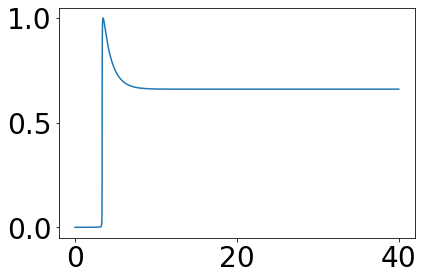

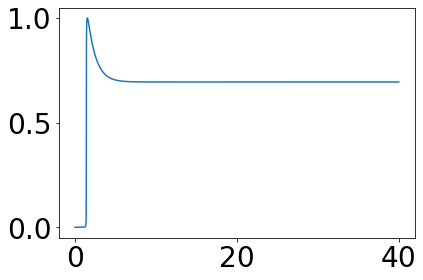

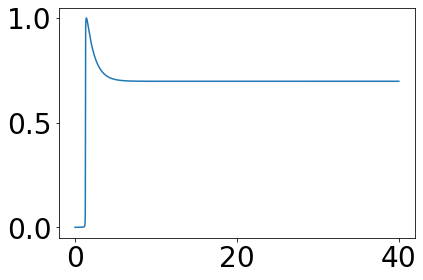

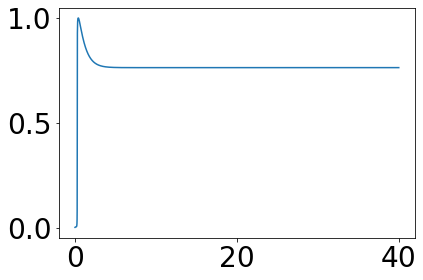

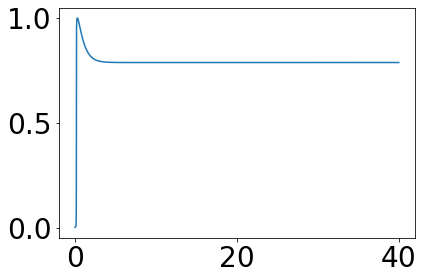

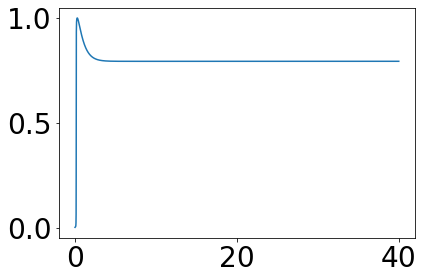

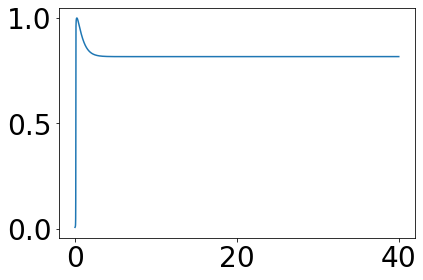

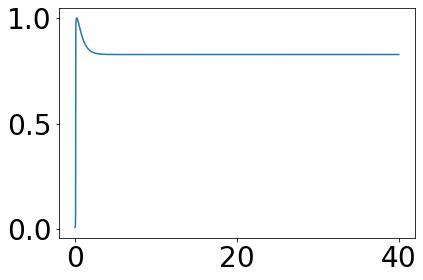

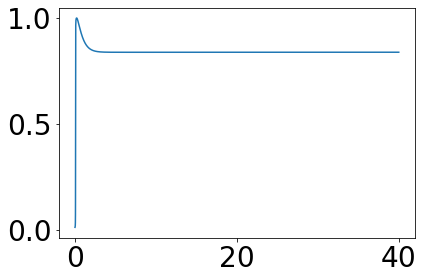

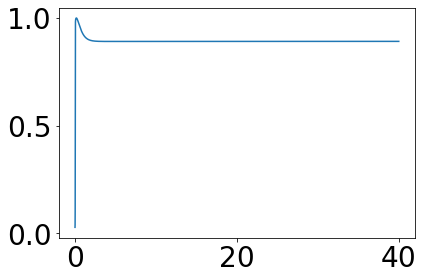

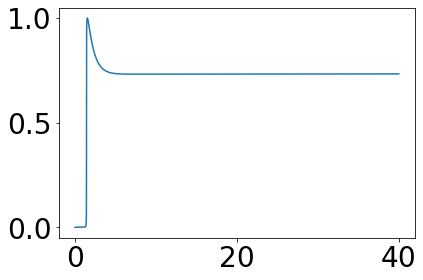

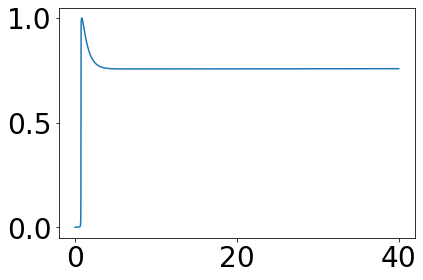

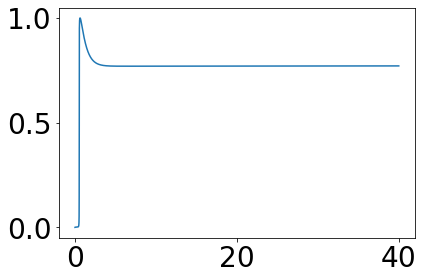

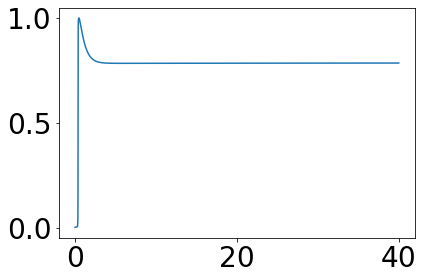

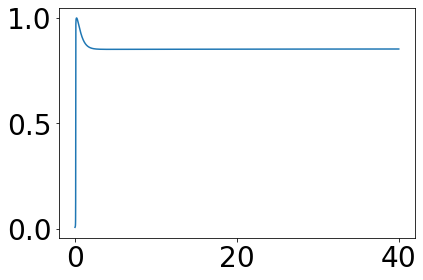

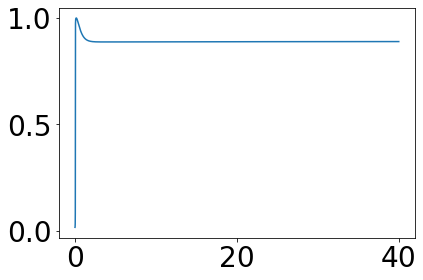

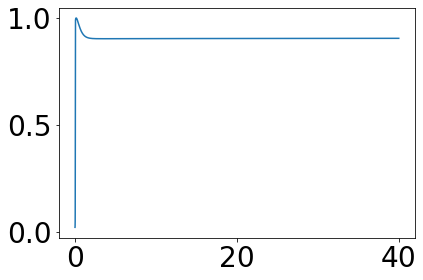

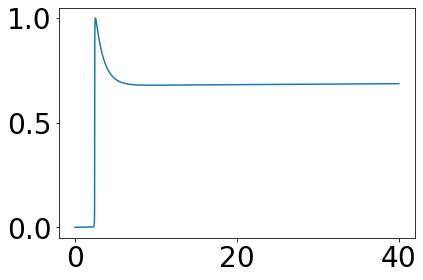

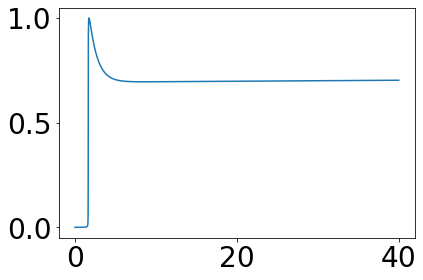

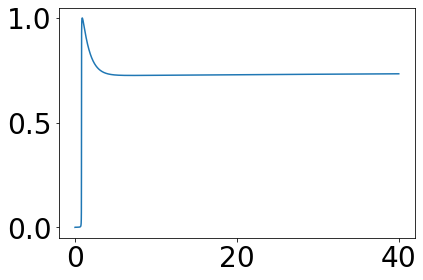

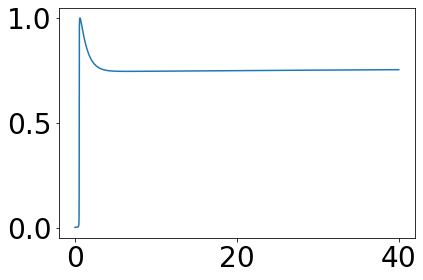

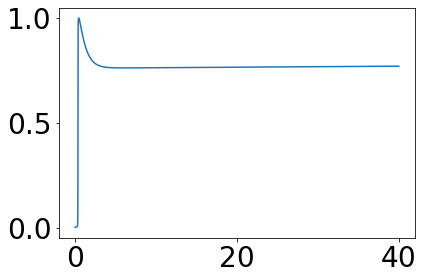

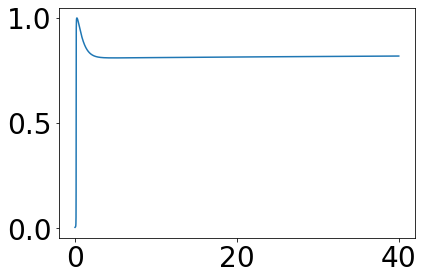

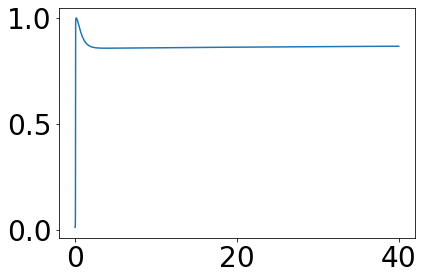

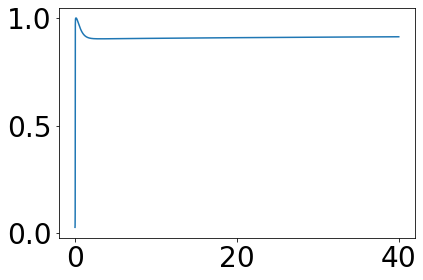

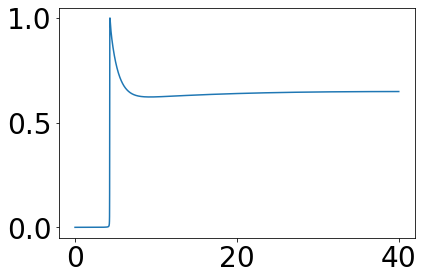

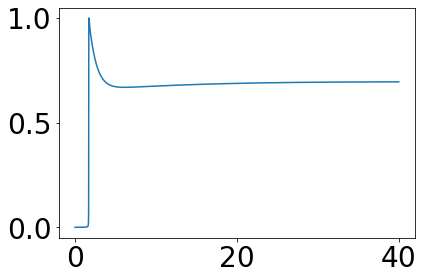

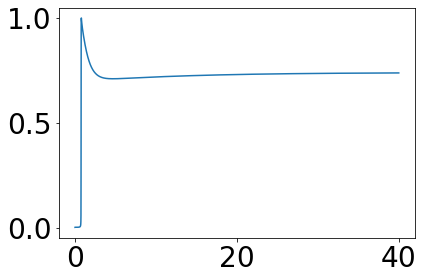

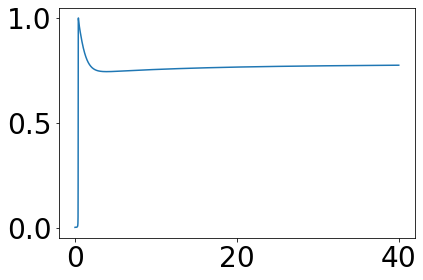

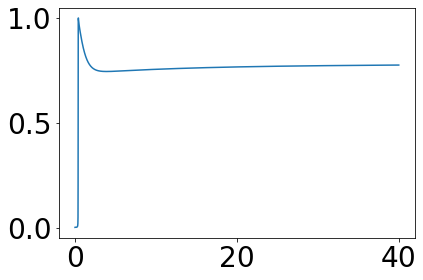

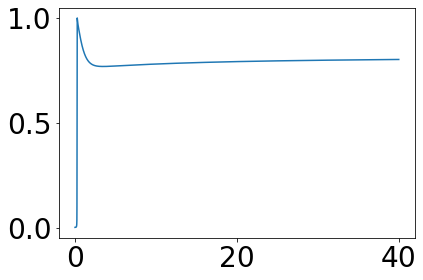

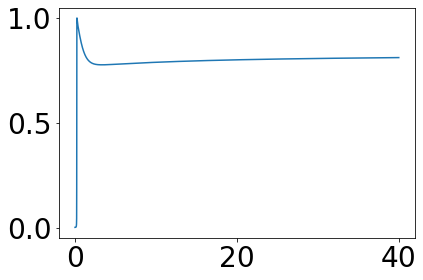

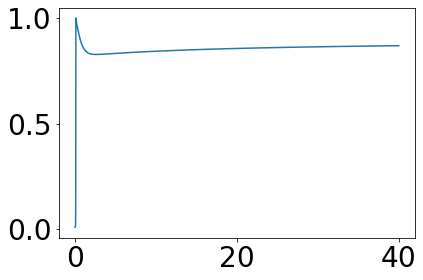

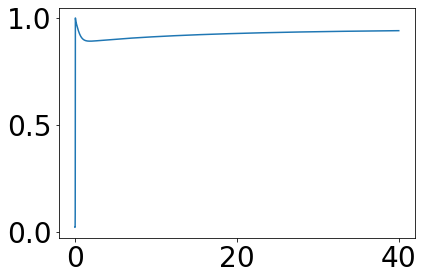

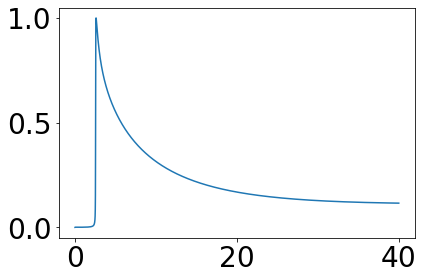

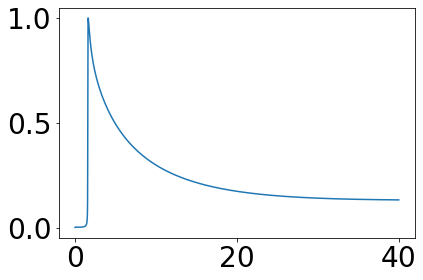

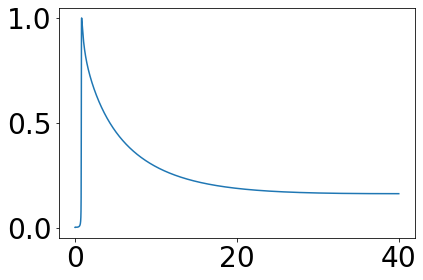

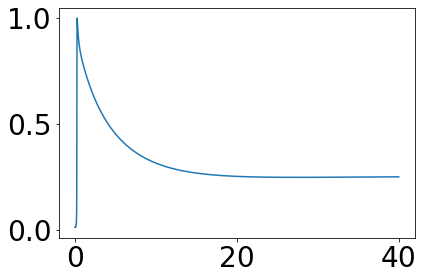

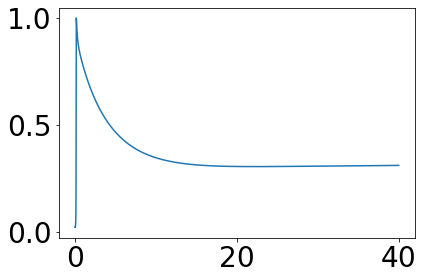

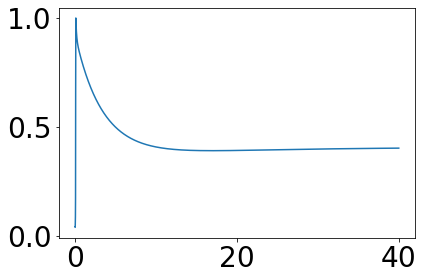

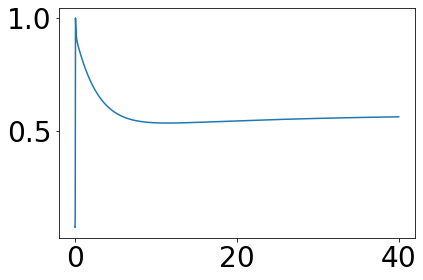

In [32]:
#for renaming species in RMG reactions
master_dict ={'CHF2(727)': 'CHF2',
 'O2(3)': 'O2',
 'S(891)': 'CHF2OO',
 'CF2O(694)': 'CF2O',
 'OH(7)': 'OH',
 'CHF(686)': 'CHF',
 'HF(684)': 'HF',
 'CH2F2(1)': 'CH2F2',
 'S(1006)': 'CHF2CHF2',
 'CHF2O(895)': 'CHF2O',
 'O(6)': 'O',
 'H(5)': 'H',
 'H2(8)': 'H2',
 'S(1186)': 'OObrackCbrack(F)F',
 'C2HF3(700)': 'CHFCF2',
 'CHFO(692)': 'CHFO',
 'C2H4(12)': 'C2H4',
 'C2H3(17)': 'C2H3',
 'H2O(4)': 'H2O',
 'HCO(14)': 'HCO',
 'CO(22)': 'CO',
 'CF2(688)': 'CF2',
 'C2HF4(714)': 'CHF2CF2',
 'S(1191)': 'CHF2CF',
 'CFO2(1340)': 'CFO2',
 'C2HF2(717)': 'CHFCF',
 'C3H7O2(98)': 'IC3H7O2',
 'CH3(13)': 'CH3',
 'CH4(21)': 'CH4',
 'C3H5-A(94)': 'C3H5-A',
 'CH2O(19)': 'CH2O',
 'C3H6(95)': 'C3H6',
 'HO2(10)': 'HO2',
 'C2H2(23)': 'C2H2',
 'H2O2(11)': 'H2O2',
 'C3H8(2)': 'C3H8',
 'NC3H7(92)': 'NC3H7',
 'IC3H7(93)': 'IC3H7',
 'C3H4(169)': 'C3H4',
 'C3H3(66)': 'C3H3',
 'CH2CO(20)': 'CH2CO',
 'C2F2(705)': 'FCCF',
 'C2H(28)': 'C2H',
 'CH2(18)': 'CH2',
 'CH2CHO(16)': 'CH2CHO'}



#reactions that we will be focusing on (does not include sens RMG reactions already in the N_B mech)

#sens_rxns_not_included_in_N_B =[321, 476, 224, 341, 218, 484, 347, 222, 947, 219]# 531] #not including 341, this will be coming from brown3. Also not including 676 and 725 and 531 

#ANL_Brown3_tries
sens_rxns_not_included_in_N_B =[476, 224, 218, 484, 347, 222, 947, 219]#for Brown3, adding in 341 
#sens_rxns_not_included_in_N_B =[476, 224, 218, 484, 347, 222, 947, 219, 341]#for Brown3, adding in 341 
#sens_rxns_not_included_in_N_B =[476, 224, 218, 484, 347, 222, 947, 219, 341, 508, 321, 386, 670, 504, 534]#for Brown3, adding in 341 

#sens_rxns_not_included_in_N_B =[476, 224, 218, 484, 347, 222, 219 ]#for Brown3 
#sens_rxns_not_included_in_N_B =[476, 224, 218, 347, 222, 219 ]#for Brown3 
#sens_rxns_not_included_in_N_B =[476, 224, 218, 347, 222]#for Brown3 
#sens_rxns_not_included_in_N_B =[476, 224, 218, 347, 222]#for Brown3 
#sens_rxns_not_included_in_N_B =[476, 347, 222]#for Brown3 
#sens_rxns_not_included_in_N_B =[347, 222]#for Brown3 
#sens_rxns_not_included_in_N_B =[347, 222]#for Brown3 
#sens_rxns_not_included_in_N_B =[476, 347]#for Brown3 
#sens_rxns_not_included_in_N_B =[476, 224, 218, 484, 347, 222, 947, 219, 676, 725]#for Brown3 



#let's change the names of the reactants and products of these RMG reactions
for sens_index in sens_rxns_not_included_in_N_B: 
    
    interesting_rxn = RMG_gas.reactions()[sens_index]
    
    #now lets change the reactants to NUIG_Brown names
    new_names_reactants = {}
    for reactant, num in interesting_rxn.reactants.items(): 
        #now replace with NUIG_Brown names
        new_names_reactants[master_dict[reactant]] = num
    
    
    #now lets change the products to NUIG_Brown names
    new_names_products = {}
    for product, num in interesting_rxn.products.items(): 
        new_names_products[master_dict[product]] = num
    
    #now let's save these new names in the reaction.
    interesting_rxn.reactants = new_names_reactants
    interesting_rxn.products = new_names_products
    
    
    
    


                 
excluded_rxn = 'no_organics_sens_rxns'#,
# 321 ,
# 386 ,
# 476 ,
# 569 ,
# 224 ,
# 341 ,
# 201 ,
# 534 ,
# 218 ,
# 131 ,
# 676 ,
# 484 ,
# 670 ,
# 347 ,
# 508 ,
# 222 ,
# 947 ,
# 504 ,
# 219 ,
# 725 ,
# 531 ]





before = len(N_B_gas.reactions())
print(f'Before addition: {before}')
for index in sens_rxns_not_included_in_N_B:
    print(f'adding in {RMG_gas.reaction(index)} from RMG')
    N_B_gas.add_reaction(RMG_gas.reaction(index))
after = len(N_B_gas.reactions())

print(f'After addition: {after}')

#check to see if addition happened
assert after>before, "But did you really add RMG reactions tho? Think again."     
    
######## now let's calculate the ign delay ##########

#ign delay function 

def find_id(time,data):
    m = len(data)
    diff = np.zeros(m)
    diff_l = np.zeros(m)
    diff_r = np.zeros(m)
    a = 0
    for i in range(m):
        if i>1 and i<m-1:
            diff_l[i] = (data[i] - data[i-1])/(time[i]-time[i-1])
            diff_r[i] = (data[i+1] - data[i])/(time[i+1]-time[i])
            diff[i] = (diff_l[i]+diff_r[i])/2
    a = np.max(diff) #slope,m
    b = np.argmax(diff) #location of slope, x1
    
    
    #making of the function (y-y1 = m(x-x1)) 
    y = data[b] #location of y1
    x = time[b]  #location of x1 in terms of the modified time s
    
    #added by Nora 
    print(f'slope (a): {a}, location of slope (b): {b}, y: {y}, x: {x}')
    
    t_id = -y/a+x #ignition delay location
    
    
    #returning the slope approximation function 
    
    lo = x-0.005
    hi = x+0.005
   
    x_0  = np.linspace(lo,hi)
    y_0 = a*(x_0-x)+y
    print(f'in the find_id function, found :{t_id}')
    return diff,t_id,x_0,y_0

########### let's get the right temps 

#doping data, eduardos experiments 

no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_label, no_CH2F2_color, no_CH2F2_shape  = [[0.63269666, 0.56358202, 0.61326454, 0.62338108, 0.6588242,  0.74256908,
 0.77973157, 0.74591045, 0.65343648, 0.6813308], 
 [0.140397, 0.03592654, 0.08382547, 0.1015549,  0.21059732, 1.74050565,
 3.16531584, 1.67252058, 0.19990897, 0.36081361], '0% CH$_2$F$_2$', 'k', 's']
                                                                      
                    
pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_label, pt1_CH2F2_color,  pt1_CH2F2_shape =[[0.71625797, 0.56876523, 0.58520137, 0.6216291, 0.70274495, 0.68888998,
 0.74213088], 
 [1.21382961, 0.0471075,  0.07372893, 0.12092486, 0.67064511, 0.55730096,
 2.02355779], '0.1% CH$_2$F$_2$', 'm', 's']
                                                          
    
pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_label, pt5_CH2F2_color,  pt5_CH2F2_shape  = [[0.64051452, 0.74256407, 0.75806182, 0.59921964, 0.55737473, 0.69714701,
 0.71456021, 0.68253075], 
 [0.19242997, 2.08706923, 2.24174715, 0.08639935, 0.04194953, 0.63637152,
 1.06022888, 0.4540505 ], '0.5% CH$_2$F$_2$', 'c', 'v'] 

_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_label, _2_CH2F2_color,  _2_CH2F2_shape = [[0.6014515, 0.72489571, 0.76260487, 0.63965302, 0.64586785, 0.66499352,
 0.66447004, 0.69194404, 0.55187601], 
 [0.12278134, 2.15618223, 3.8948634,  0.28953096, 0.36193926, 0.57132118,
 0.62294087, 1.16312355, 0.051226],  '2% CH$_2$F$_2$', 'b', '^']

_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_label, _4_CH2F2_color,  _4_CH2F2_shape = [[0.59342286, 0.56586408, 0.61717534, 0.66810691, 0.69578168, 0.71392225,
 0.52988636], 
 [0.2396125, 0.13106904, 0.40859232, 1.46789449, 2.3113845,  2.8922329,
 0.06264836], '4% CH$_2$F$_2$', 'g', 'o']


temps_for_0 = sorted([1000/T_inv for T_inv in no_CH2F2_temps_inv])
temps_for_0_1 = sorted([1000/T_inv for T_inv in pt1_CH2F2_temps_inv])
temps_for_0_5 = sorted([1000/T_inv for T_inv in pt5_CH2F2_temps_inv])
temps_for_2 = sorted([1000/T_inv for T_inv in _2_CH2F2_temps_inv])
temps_for_4 = sorted([1000/T_inv for T_inv in _4_CH2F2_temps_inv])


##### ign delay calculation 

gas = N_B_gas

#P5_1 = [0.96603599, 1.00671102, 0.95991744, 0.95928503, 0.98402179,
#       1.02082774, 1.02725268] #actual pressures that he measured?
#P5_real = np.mean(P5_1)

specific_temps = {0: temps_for_0,
0.1: temps_for_0_1,
0.5: temps_for_0_5,
2: temps_for_2,
4: temps_for_4}


X_list = [0,0.1,0.5,2,4]
concentrations = ['0','0.1', '0.5', '2', '4']
conc_names = ['CH2F2:0, C3H8: 1, O2: 6, Ar:93','CH2F2:0.11,C3H8:1.1,O2:6,Ar:92.13','CH2F2:0.52,C3H8:1,O2:6,Ar:92.5','CH2F2:2,C3H8:1.1,O2:6,Ar:90.9','CH2F2:1.99,C3H8:0.5,O2:3,Ar:94.7']
 
pressure_dict = {0: 1,  #I'm just assuming this is 1 atm for no CH2F2, there's actually no csv file for it
    0.1:  1.0127232051380075,
    0.5:  1.0158269373681306, 
    2: 1.012855580622881,
    4: 0.9891502432791955}

master_dict={}

for index, x in enumerate(X_list): 

    #mole_frac_dict = {"CH2F2":x, "C3H8": 1, "O2": 5, "AR":94-x} 
    # mole_frac_dict = {"CH2F2":x, "C3H8": 1, "O2": 6, "AR":93-x} 
    
    temps_we_want = specific_temps[x]
    print(temps_we_want)
    
    mole_frac_dict = conc_names[index]
    print(conc_names)
    
    t_id_nuig = np.zeros(len(temps_we_want))
    for i in range(len(temps_we_want)):
        print(f'starting {temps_we_want[i]} of {concentrations[index]}% CH2F2')
        # if temps_we_want[i]>1820:
        #     dt_max = 5e-6
        #     t_end = (2000 * dt_max)*2              
        # if temps_we_want[i]>1700:
        #     dt_max = 5e-6
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i]>1600 and temps_we_want[i]<=1700:
        #     dt_max = 1e-5
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i]>1400 and temps_we_want[i]<=1600:
        #     dt_max = 2.5e-5
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i]<=1400 and temps_we_want[i]>1300:
        #     dt_max = 5e-5
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i] <= 1300:
        #     dt_max = 7.5e-5
        #     t_end = (2000 * dt_max)*1.5
            
            
        gas.TPX = temps_we_want[i],pressure_dict[x]*ct.one_atm, mole_frac_dict
        r = ct.Reactor(contents=gas)


        sim = ct.ReactorNet([r])
        sim.verbose = True

        # delta_T_max = 1
        # r.set_advance_limit('temperature', delta_T_max)


        states = ct.SolutionArray(gas, extra=['t'])
        
        dt_max = 5e-6
        t_end = (2000 * dt_max)*4

        while sim.time < t_end:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time*1e3)
            
        print(f"Max: {np.max(states.X[:, gas.species_index('OH')])}")
        print(f"mole fractions of OH: {states.X[:, gas.species_index('OH')]}")
        
        diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH')]/np.max(states.X[:, gas.species_index('OH')]))
        t_id_nuig[i] = t_id #id in ms
        
        plt.figure()
        plt.plot(states.t,states.X[:, gas.species_index('OH')]/np.max(states.X[:, gas.species_index('OH')]))
#     #save the data   
    master_dict[x] = t_id_nuig

    
    
print(f'Ignition delays for excluded rxn {excluded_rxn} are:\nFor 0: np.{master_dict[0]}\nFor 0.1:  np.{master_dict[0.1]}\nFor 0.5:  np.{master_dict[0.5]}\nFor 2:  np.{master_dict[2]}\nFor 4:  np.{master_dict[4]}')     

In [98]:
master_dict #ANL+Brown3+ RMG

{0: array([3.34512241, 1.39578106, 1.27774072, 0.27463596, 0.16451499,
        0.14362281, 0.09486718, 0.07817588, 0.06461476, 0.02606464]),
 0.1: array([1.41349326, 0.72792387, 0.51849044, 0.36954524, 0.08439899,
        0.0394163 , 0.03164081]),
 0.5: array([2.38779075, 1.6103094 , 0.78851533, 0.51187515, 0.35995021,
        0.13939723, 0.06078094, 0.02504249]),
 2: array([4.03002089, 1.62961536, 0.74016534, 0.3951415 , 0.39044319,
        0.25591412, 0.22080262, 0.09597461, 0.03656193]),
 4: array([2.52261931, 1.60556033, 0.82096931, 0.25695438, 0.15430571,
        0.08824276, 0.04400231])}

/tmp/ipykernel_22477/1228166649.py:68: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,10)


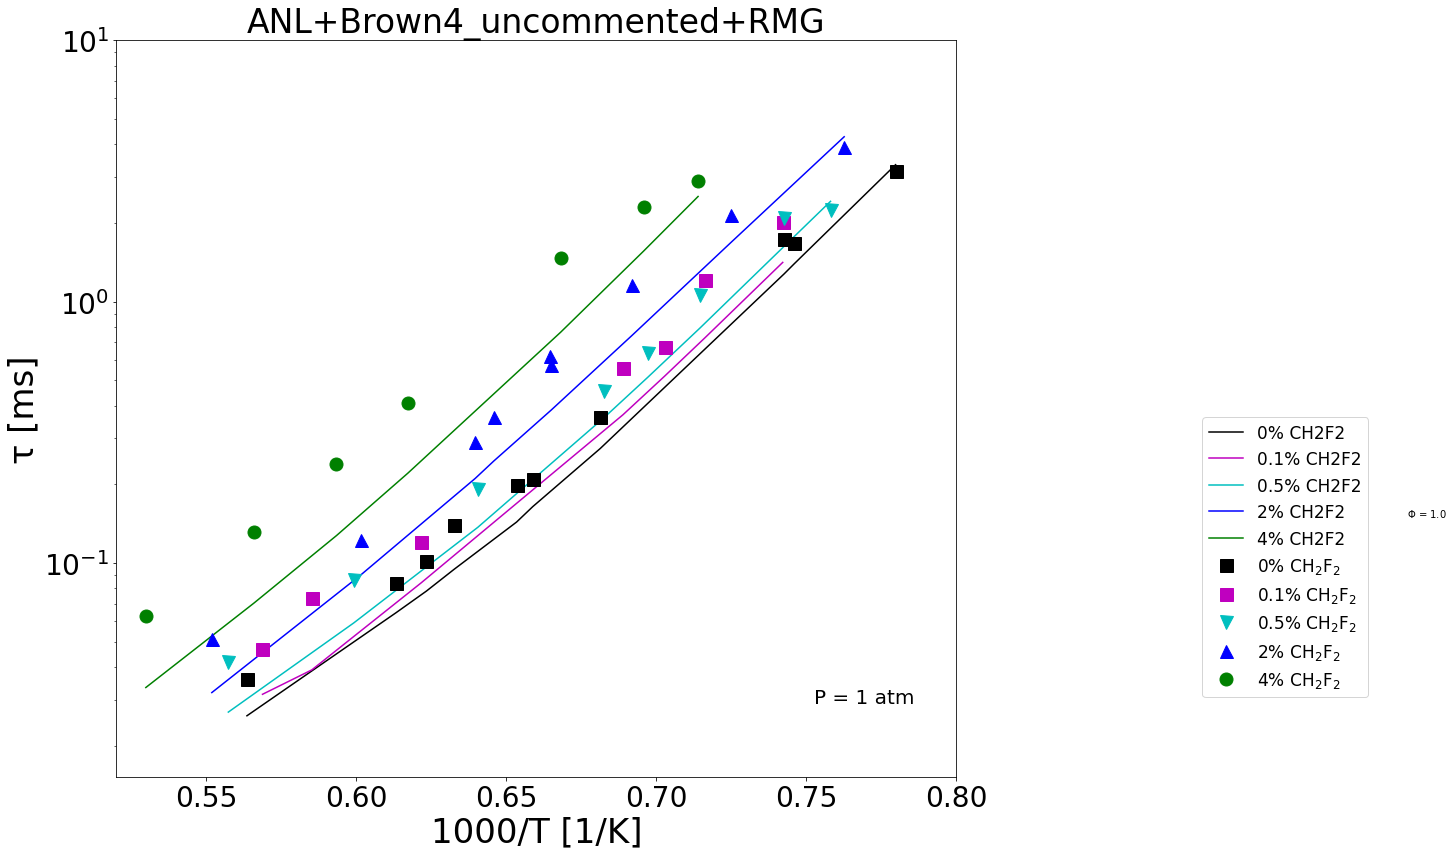

In [34]:
#doping data, eduardos experiments , ONLY PROPANE

                                             
#PLOTTING SECTION
plt.rcParams['figure.figsize'] = (24, 12)
plt.rcParams['axes.labelsize'] = 34
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'Times New Roman'

#my model
X_list = [0,0.1,0.5,2,4]
colors = [no_CH2F2_color,
pt1_CH2F2_color,
pt5_CH2F2_color,
_2_CH2F2_color,
_4_CH2F2_color]

# X_list = [0]
# colors = [no_CH2F2_color]

exp_taus = {0: np.array(no_CH2F2_taus),
0.1: np.array(pt1_CH2F2_taus),
0.5: np.array(pt5_CH2F2_taus),
2: np.array(_2_CH2F2_taus),
4: np.array(_4_CH2F2_taus)}

#to save RMSE values for each line
RMSEs = {}


#plot values and calculate RMSE and slopes  
average_slopes = []
for x, color in zip(X_list, colors):
    taus = master_dict[x]
    taus_to_plot = np.array(taus)#[tau for tau in taus if tau>0])
    exp_values = exp_taus[x]
    
    #RMSE
    n = len(exp_values) 
    y_hat = taus_to_plot
    y = exp_values
    RMSE = np.sqrt((1/n) * sum(np.square(y - y_hat)))
    RMSEs[x] = RMSE
    
    #slope differences 
    temps_to_plot = [1000/T for T in specific_temps[x]]
    
    # average_slope = get_average_slope(taus_to_plot, temps_to_plot) 
    # average_slopes.append(average_slope)
    
 
    #temps_to_plot = T5_inverse[0:len(taus_to_plot)]
    plt.semilogy([1000/T for T in specific_temps[x]], taus_to_plot, '-', c=color, label=f'{x}% CH2F2', markersize=16) 

#compare the slopes
# slope_comparison = compare_slopes(average_slopes, average_slopes[-1])


#experiments
plt.semilogy((100/1774.364625755804),0.019915305120217417, '*')
plt.semilogy(no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_shape, c=no_CH2F2_color, label=no_CH2F2_label, markersize=13) 
plt.semilogy(pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_shape, c=pt1_CH2F2_color, label=pt1_CH2F2_label, markersize=13) 
plt.semilogy(pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_shape, c=pt5_CH2F2_color, label=pt5_CH2F2_label, markersize=13) 
plt.semilogy(_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_shape, c=_2_CH2F2_color, label=_2_CH2F2_label, markersize=13) 
plt.semilogy(_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_shape, c=_4_CH2F2_color, label=_4_CH2F2_label, markersize=13) 
plt.ylim(0,10)
plt.xlim(0.52,0.8)
plt.xlabel('1000/T [1/K]')
plt.ylabel('τ [ms]')
plt.legend(fontsize=17, bbox_to_anchor=(1.5, 0.5))
#plt.text(0.95, 0.05, r'$\mathrm{C2H8:1, O2:6, Ar:93}$', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.10, 'P = 1 atm', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
# plt.text(0.95,1, f'RMSE\n{RMSEs[0]}\n{RMSEs[0.1]}\n{RMSEs[0.5]}\n{RMSEs[2]}\n{RMSEs[4]}\n{RMSEs[4]}')#, transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
# plt.text(0.85,1, f'Slope Comparison: {slope_comparison}')# transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.15, '$\Phi$ = 1.0')#  transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)


#calculate RMSE 



plt.title('ANL+Brown4_uncommented+RMG', fontsize=33)
plt.show()
    

SWITCHING KINETICS 

In [ ]:
#for renaming species in RMG reactions
master_dict ={'CHF2(727)': 'CHF2',
 'O2(3)': 'O2',
 'S(891)': 'CHF2OO',
 'CF2O(694)': 'CF2O',
 'OH(7)': 'OH',
 'CHF(686)': 'CHF',
 'HF(684)': 'HF',
 'CH2F2(1)': 'CH2F2',
 'S(1006)': 'CHF2CHF2',
 'CHF2O(895)': 'CHF2O',
 'O(6)': 'O',
 'H(5)': 'H',
 'H2(8)': 'H2',
 'S(1186)': 'OObrackCbrack(F)F',
 'C2HF3(700)': 'CHFCF2',
 'CHFO(692)': 'CHFO',
 'C2H4(12)': 'C2H4',
 'C2H3(17)': 'C2H3',
 'H2O(4)': 'H2O',
 'HCO(14)': 'HCO',
 'CO(22)': 'CO',
 'CF2(688)': 'CF2',
 'C2HF4(714)': 'CHF2CF2',
 'S(1191)': 'CHF2CF',
 'CFO2(1340)': 'CFO2',
 'C2HF2(717)': 'CHFCF',
 'C3H7O2(98)': 'IC3H7O2',
 'CH3(13)': 'CH3',
 'CH4(21)': 'CH4',
 'C3H5-A(94)': 'C3H5-A',
 'CH2O(19)': 'CH2O',
 'C3H6(95)': 'C3H6',
 'HO2(10)': 'HO2',
 'C2H2(23)': 'C2H2',
 'H2O2(11)': 'H2O2',
 'C3H8(2)': 'C3H8',
 'NC3H7(92)': 'NC3H7',
 'IC3H7(93)': 'IC3H7',
 'C3H4(169)': 'C3H4',
 'C3H3(66)': 'C3H3',
 'CH2CO(20)': 'CH2CO',
 'C2F2(705)': 'FCCF',
 'C2H(28)': 'C2H',
 'CH2(18)': 'CH2',
 'CH2CHO(16)': 'CH2CHO'}



#reactions that we will be focusing on (does not include sens RMG reactions already in the N_B mech)



sens_rxns_not_included_in_N_B =[321,
 386,
 476,
 224,
 341,
 534,
 218,
 676,
 484,
 670,
 347,
 508,
 222,
 947,
 504,
 219,
 725,
 531] #best result 
#these were taking out all organic reactions, sens_rxns_no_organics




#let's change the names of the reactants and products of these RMG reactions
for sens_index in sens_rxns_not_included_in_N_B: 
    
    interesting_rxn = RMG_gas.reactions()[sens_index]
    
    #now lets change the reactants to NUIG_Brown names
    new_names_reactants = {}
    for reactant, num in interesting_rxn.reactants.items(): 
        #now replace with NUIG_Brown names
        new_names_reactants[master_dict[reactant]] = num
    
    
    #now lets change the products to NUIG_Brown names
    new_names_products = {}
    for product, num in interesting_rxn.products.items(): 
        new_names_products[master_dict[product]] = num
    
    #now let's save these new names in the reaction.
    interesting_rxn.reactants = new_names_reactants
    interesting_rxn.products = new_names_products
    
    
    
    


                 
excluded_rxn = 'no_organics_sens_rxns'#,
# 321 ,
# 386 ,
# 476 ,
# 569 ,
# 224 ,
# 341 ,
# 201 ,
# 534 ,
# 218 ,
# 131 ,
# 676 ,
# 484 ,
# 670 ,
# 347 ,
# 508 ,
# 222 ,
# 947 ,
# 504 ,
# 219 ,
# 725 ,
# 531 ]





before = len(N_B_gas.reactions())
print(f'Before addition: {before}')
for index in sens_rxns_not_included_in_N_B:
    N_B_gas.add_reaction(RMG_gas.reaction(index))

#let's delete all of the rxns that were already in N_B and replace it with the RMG_reaction
N_B_rxn_indices_to_replace = [11, 204, 1, 109, 207, 4, 205, 129, 206]

for index in N_B_rxn_indices_to_replace: 
    N_B_gas.set_multiplier(0, index)
    print(f'setting rate for 0 for {N_B_gas.reaction(index)}')
    
#now add in the RMG reactions to replace these: 


non_organics_index_for_kinetics_replacements = [213, 386, 211, 341, 534, 212, 670, 508, 504]
non_organics_for_kinetics_replacements = [RMG_gas.reaction(i) for i in non_organics_index_for_kinetics_replacements]

#change species names 
for index, interesting_rxn in zip(non_organics_index_for_kinetics_replacements, non_organics_for_kinetics_replacements): 
    #print(interesting_rxn)
    #now lets change the reactants to NUIG_Brown names
    new_names_reactants = {}
    for reactant, num in interesting_rxn.reactants.items(): 
        #now replace with NUIG_Brown names
        if reactant in master_dict.keys():
            new_names_reactants[master_dict[reactant]] = num
        else: 
            pass
    #print(new_names_reactants,interesting_rxn.reactants) 
    
    
    #now lets change the reactants to NUIG_Brown names
    new_names_products = {}
    for product, num in interesting_rxn.products.items(): 
        #now replace with NUIG_Brown names
        if product in master_dict.keys():
            new_names_products[master_dict[product]] = num
        else:
            pass
    #print(new_names_products,interesting_rxn.products) 
    
    #now let's save these new names in the reaction.
    if new_names_reactants != {}:
        interesting_rxn.reactants = new_names_reactants
        interesting_rxn.products = new_names_products
    else: 
        pass 
    

#let's look through 

for index in non_organics_index_for_kinetics_replacements:
    N_B_gas.add_reaction(RMG_gas.reaction(index))
    print(f'adding in {RMG_gas.reaction(index)}')



after = len(N_B_gas.reactions())

print(f'After addition: {after}')

#check to see if addition happened
assert after>before, "But did you really add RMG reactions tho? Think again."     
    
######## now let's calculate the ign delay ##########

#ign delay function 

def find_id(time,data):
    m = len(data)
    diff = np.zeros(m)
    diff_l = np.zeros(m)
    diff_r = np.zeros(m)
    a = 0
    for i in range(m):
        if i>1 and i<m-1:
            diff_l[i] = (data[i] - data[i-1])/(time[i]-time[i-1])
            diff_r[i] = (data[i+1] - data[i])/(time[i+1]-time[i])
            diff[i] = (diff_l[i]+diff_r[i])/2
    a = np.max(diff) #slope,m
    b = np.argmax(diff) #location of slope, x1
    
    
    #making of the function (y-y1 = m(x-x1)) 
    y = data[b] #location of y1
    x = time[b]  #location of x1 in terms of the modified time s
    
    #added by Nora 
    print(f'slope (a): {a}, location of slope (b): {b}, y: {y}, x: {x}')
    
    t_id = -y/a+x #ignition delay location
    
    
    #returning the slope approximation function 
    
    lo = x-0.005
    hi = x+0.005
   
    x_0  = np.linspace(lo,hi)
    y_0 = a*(x_0-x)+y
    print(f'in the find_id function, found :{t_id}')
    return diff,t_id,x_0,y_0

########### let's get the right temps 

#doping data, eduardos experiments 

no_CH2F2_temps_inv, no_CH2F2_taus, no_CH2F2_label, no_CH2F2_color, no_CH2F2_shape  = [[0.63269666, 0.56358202, 0.61326454, 0.62338108, 0.6588242,  0.74256908,
 0.77973157, 0.74591045, 0.65343648, 0.6813308], 
 [0.140397, 0.03592654, 0.08382547, 0.1015549,  0.21059732, 1.74050565,
 3.16531584, 1.67252058, 0.19990897, 0.36081361], '0% CH$_2$F$_2$', 'k', 's']
                                                                      
                    
pt1_CH2F2_temps_inv, pt1_CH2F2_taus, pt1_CH2F2_label, pt1_CH2F2_color,  pt1_CH2F2_shape =[[0.71625797, 0.56876523, 0.58520137, 0.6216291, 0.70274495, 0.68888998,
 0.74213088], 
 [1.21382961, 0.0471075,  0.07372893, 0.12092486, 0.67064511, 0.55730096,
 2.02355779], '0.1% CH$_2$F$_2$', 'm', 's']
                                                          
    
pt5_CH2F2_temps_inv, pt5_CH2F2_taus, pt5_CH2F2_label, pt5_CH2F2_color,  pt5_CH2F2_shape  = [[0.64051452, 0.74256407, 0.75806182, 0.59921964, 0.55737473, 0.69714701,
 0.71456021, 0.68253075], 
 [0.19242997, 2.08706923, 2.24174715, 0.08639935, 0.04194953, 0.63637152,
 1.06022888, 0.4540505 ], '0.5% CH$_2$F$_2$', 'c', 'v'] 

_2_CH2F2_temps_inv, _2_CH2F2_taus, _2_CH2F2_label, _2_CH2F2_color,  _2_CH2F2_shape = [[0.6014515, 0.72489571, 0.76260487, 0.63965302, 0.64586785, 0.66499352,
 0.66447004, 0.69194404, 0.55187601], 
 [0.12278134, 2.15618223, 3.8948634,  0.28953096, 0.36193926, 0.57132118,
 0.62294087, 1.16312355, 0.051226],  '2% CH$_2$F$_2$', 'b', '^']

_4_CH2F2_temps_inv, _4_CH2F2_taus, _4_CH2F2_label, _4_CH2F2_color,  _4_CH2F2_shape = [[0.59342286, 0.56586408, 0.61717534, 0.66810691, 0.69578168, 0.71392225,
 0.52988636], 
 [0.2396125, 0.13106904, 0.40859232, 1.46789449, 2.3113845,  2.8922329,
 0.06264836], '4% CH$_2$F$_2$', 'g', 'o']


temps_for_0 = sorted([1000/T_inv for T_inv in no_CH2F2_temps_inv])
temps_for_0_1 = sorted([1000/T_inv for T_inv in pt1_CH2F2_temps_inv])
temps_for_0_5 = sorted([1000/T_inv for T_inv in pt5_CH2F2_temps_inv])
temps_for_2 = sorted([1000/T_inv for T_inv in _2_CH2F2_temps_inv])
temps_for_4 = sorted([1000/T_inv for T_inv in _4_CH2F2_temps_inv])


##### ign delay calculation 

gas = N_B_gas

#P5_1 = [0.96603599, 1.00671102, 0.95991744, 0.95928503, 0.98402179,
#       1.02082774, 1.02725268] #actual pressures that he measured?
#P5_real = np.mean(P5_1)

specific_temps = {0: temps_for_0,
0.1: temps_for_0_1,
0.5: temps_for_0_5,
2: temps_for_2,
4: temps_for_4}


X_list = [0,0.1,0.5,2,4]
concentrations = ['0','0.1', '0.5', '2', '4']
conc_names = ['CH2F2:0, C3H8: 1, O2: 6, Ar:93','CH2F2:0.11,C3H8:1.1,O2:6,Ar:92.13','CH2F2:0.52,C3H8:1,O2:6,Ar:92.5','CH2F2:2,C3H8:1.1,O2:6,Ar:90.9','CH2F2:1.99,C3H8:0.5,O2:3,Ar:94.7']
 
pressure_dict = {0: 1,  #I'm just assuming this is 1 atm for no CH2F2, there's actually no csv file for it
    0.1:  1.0127232051380075,
    0.5:  1.0158269373681306, 
    2: 1.012855580622881,
    4: 0.9891502432791955}

master_dict={}

for index, x in enumerate(X_list): 

    #mole_frac_dict = {"CH2F2":x, "C3H8": 1, "O2": 5, "AR":94-x} 
    # mole_frac_dict = {"CH2F2":x, "C3H8": 1, "O2": 6, "AR":93-x} 
    
    temps_we_want = specific_temps[x]
    print(temps_we_want)
    
    mole_frac_dict = conc_names[index]
    print(conc_names)
    
    t_id_nuig = np.zeros(len(temps_we_want))
    for i in range(len(temps_we_want)):
        print(f'starting {temps_we_want[i]} of {concentrations[index]}% CH2F2')
        # if temps_we_want[i]>1820:
        #     dt_max = 5e-6
        #     t_end = (2000 * dt_max)*2              
        # if temps_we_want[i]>1700:
        #     dt_max = 5e-6
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i]>1600 and temps_we_want[i]<=1700:
        #     dt_max = 1e-5
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i]>1400 and temps_we_want[i]<=1600:
        #     dt_max = 2.5e-5
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i]<=1400 and temps_we_want[i]>1300:
        #     dt_max = 5e-5
        #     t_end = (2000 * dt_max)*1.5
        # if temps_we_want[i] <= 1300:
        #     dt_max = 7.5e-5
        #     t_end = (2000 * dt_max)*1.5
            
            
        gas.TPX = temps_we_want[i],pressure_dict[x]*ct.one_atm, mole_frac_dict
        r = ct.Reactor(contents=gas)


        sim = ct.ReactorNet([r])
        sim.verbose = True

        # delta_T_max = 1
        # r.set_advance_limit('temperature', delta_T_max)


        states = ct.SolutionArray(gas, extra=['t'])
        
        dt_max = 5e-6
        t_end = (2000 * dt_max)*4

        while sim.time < t_end:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time*1e3)
            
        print(f"Max: {np.max(states.X[:, gas.species_index('OH')])}")
        print(f"mole fractions of OH: {states.X[:, gas.species_index('OH')]}")
        
        diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH')]/np.max(states.X[:, gas.species_index('OH')]))
        t_id_nuig[i] = t_id #id in ms
        
        plt.figure()
        plt.plot(states.t,states.X[:, gas.species_index('OH')]/np.max(states.X[:, gas.species_index('OH')]))
#     #save the data   
    master_dict[x] = t_id_nuig

    
    
print(f'Ignition delays for excluded rxn {excluded_rxn} are:\nFor 0: np.{master_dict[0]}\nFor 0.1:  np.{master_dict[0.1]}\nFor 0.5:  np.{master_dict[0.5]}\nFor 2:  np.{master_dict[2]}\nFor 4:  np.{master_dict[4]}')     